# Finding a scale for stratification

Stratification is a key parameter for how much water gets upwelled through a canyon. Since I am changing vertical diffusivity within the canyon and outside, I am changing the rate at which stratification is destroyed through diffusion of T and S within the canyon and outside. This calls for a function or a scale to estimate how fast this destruction happens and how different from the initial stratification, $N_o$, will the local stratification, $N$, be after some time $t_f$. 

For the canyon, I want to find what will the stratification be around the rim of the canyon at some time $t_f$ after the time dependent phase and during the advective phase as a function of the vertical diffusivity (remember in my experiments $\kappa_vT=\kappa_vS$) and the initial stratification $N_o$. Without changing $\kappa_v$, the stratifictaion in this particular place grows with time, more quickly during the time-dependent phase and larger if the initial stratification is larger (see plots below). So, I want to find, for a given $N_o$, how will Kv change the stratification at some time $t_{f}$.

First, we need a timescale for diffusion, i.e. How fast is diffusivity going to destroy the T and S gradients. To calculate that we also need a vertical scale for the gradients. We will assume we case about the stratification nead the rim of the canyon and that the vertical scale $\Delta z$ is of order 10's of meters. In that case, we can define a timescale 

$$\tau=\frac{\Delta z^2}{\kappa_v}.$$

In our experiments, $\kappa v$ within the canyon and outside varies between $10^{-3}$ $m^2/s$ to $10^{-7}$ $m^2/s$, so the timescales are

|$\kappa_v$ (m$^2$/s)|$\tau$ (s)|$\tau$ (days)|
|:--------:|:--------:|:------------|
| $10^{-3}$  | $10^5$   | 1.2         |
| $10^{-4}$  | $10^6$   | 11.6        |
| $10^{-5}$  | $10^7$   | 115.7       |
| $10^{-7}$  | $10^9$   | 11574.1     |


I want to find an expression $N = N(t_f,\tau,N_0)$ such that if $t_f\to\tau$, $N \to 0$ and if $t_f<<\tau$ then $N \to N_0$. One option is 

$$N = N_0 \frac{\tau-t_f}{\tau}$$ for $t_f < \tau$.

We will try out this expression in the following to see if it is a good approximation.

In [2]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

In [112]:
def plotN(ax,z,N,N0,lab,title):
    ax.plot(N,z,label=lab)
    ax.plot(N0,z,'--',color='grey',label='')
    ax.axhline(rc[30],linestyle='--',color='0.6')
    ax.axhline(rc[26],linestyle='--',color='0.6')
    ax.set_title(title)
    ax.set_xlabel('$N-N_0$ ($s^{-1}$)')
    ax.set_ylabel('depth (m)')

def plotRho(ax,z,rho,rho0,lab,title):
    ax.plot(rho,z,label=lab)
    ax.plot(rho0,z,'--',color='grey',label='')
    ax.axhline(rc[30],linestyle='--',color='0.6')
    ax.axhline(rc[26],linestyle='--',color='0.6')
    ax.set_title(title)
    ax.set_xlabel('rho (kg/m$^{3}$)')
    ax.set_ylabel('depth (m)')

def plot_dRho_Rho0(ax,z,rho,rho0,lab,title):
    rho_ref=999.0
    ax.plot(rho/rho_ref,z,label=lab)
    ax.axhline(rc[30],linestyle='--',color='0.6')
    ax.axhline(rc[26],linestyle='--',color='0.6')
    ax.set_title(title)
    ax.set_xlabel('(rho-rho(0))/rho_ref (kg/m$^{3}$)')
    ax.set_ylabel('depth (m)')

def plot_max_N(ax,day,N,lab,colour,msize,title,xlab):
    hand, = ax.plot(day,max(N),'o',color=sns.xkcd_rgb[colour],markersize=msize,label=lab)
    ax.set_title(title)
    ax.set_ylabel('$N$ ($s^{-1}$)')
    ax.set_xlabel(xlab)
    return hand

def plot_max_N_std(ax,day,N,stdN,lab,colour,msize,title,xlab):
    hand = ax.errorbar(day,N,yerr=stdN,marker='o',color=sns.xkcd_rgb[colour],markersize=msize,label=lab)
    ax.set_title(title)
    ax.set_ylabel('$N$ ($s^{-1}$)')
    ax.set_xlabel(xlab)
    return hand

def plot_Z_max_N(ax,day,z,N,lab,colour,msize,title):
    max_value = max(N)
    max_index = N.idxmax(axis=1)
    hand, = ax.plot(day,z[max_index],'o',color=sns.xkcd_rgb[colour],markersize=msize,label=lab)
    ax.set_title(title)
    ax.set_ylabel('Depth of max $N-N_0$ (m)')
    ax.set_xlabel('days')
    return hand

def plot_N_at_z(ax,day,N,zind1,zind2,lab,colour,msize,title,xlabel,No):
    sb_value = N[slice(zind1,zind2)].mean()+No
    std_value = N[slice(zind1,zind2)].std()
    hand = ax.errorbar(day,sb_value,std_value,marker='o',color=sns.xkcd_rgb[colour],markersize=msize,label=lab)
    ax.set_title(title)
    ax.set_ylabel('$Mean N $ ($s^{-1}$)')
    ax.set_xlabel(xlabel)
    return hand


In [114]:
def plotN2(st,expNames,col_pal):
    
    fig1= plt.figure(figsize=(16,6))

    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)
    ax3 = plt.subplot(1,4,3)
    ax4 = plt.subplot(1,4,4)

    axs = [ax1,ax2,ax3,ax4]

    sns.set_palette(col_pal)
    keys = ['N_tt06','N_tt08','N_tt14','N_tt18']
    key0 = ['N_tt00']

    for runs in expNames:

        for key,a in zip(keys,axs):

            sname = st
            filename1 = ('../results/metricsDataFrames/N_%s_%s.csv' % (runs,sname))

            df = pd.read_csv(filename1)
            df_anom=df.sub(df[key0].squeeze(),axis=0)
            plotN(a,rc[1:-1],df_anom[key],df_anom[key0],runs,('%s,%s' %(key, sname)))


    ax3.legend(loc=0)   
    plt.show()
    
    return fig1

def plotRhoProfile(st,expNames,col_pal):
    
    fig1= plt.figure(figsize=(16,6))

    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)
    ax3 = plt.subplot(1,4,3)
    ax4 = plt.subplot(1,4,4)

    axs = [ax1,ax2,ax3,ax4]

    sns.set_palette(col_pal)
    keys = ['rho_tt06','rho_tt08','rho_tt14','rho_tt18']
    key0 = ['rho_tt00']

    for runs in expNames:

        for key,a in zip(keys,axs):

            sname = st
            filename1 = ('../results/metricsDataFrames/rho_%s_%s.csv' % (runs,sname))

            df = pd.read_csv(filename1)
            col = df[key]
            col0 = df[key0]
            plotRho(a,rc[:],col,col0,runs,('%s,%s' %(key, sname)))
            
    ax3.legend(loc=0)   
    plt.show()
    
    return fig1

def plotDRhoRho0(st,expNames,col_pal):
    
    fig1= plt.figure(figsize=(16,6))

    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)
    ax3 = plt.subplot(1,4,3)
    ax4 = plt.subplot(1,4,4)

    axs = [ax1,ax2,ax3,ax4]

    sns.set_palette(col_pal)
    keys = ['rho_tt06','rho_tt08','rho_tt14','rho_tt18']
    key0 = ['rho_tt00']

    for runs in expNames:

        for key,a in zip(keys,axs):

            sname = st
            filename1 = ('../results/metricsDataFrames/rho_%s_%s.csv' % (runs,sname))

            df = pd.read_csv(filename1)
            df_anom=df.sub(df[key0].squeeze(),axis=0)
            plot_dRho_Rho0(a,rc[:],df_anom[key],df_anom[key0],runs,('%s,%s' %(key, sname)))

    ax3.legend(loc=0)   
    plt.show()
    
    return fig1
def plotMax(st,expNames,colours,sizes,exp_labels):
    
    fig1= plt.figure(figsize=(10,4))

    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    
    axs = [ax1,ax2]

    key0 = ['N_tt00']
    keys = ['N_tt00','N_tt02','N_tt04','N_tt06','N_tt08','N_tt10','N_tt12','N_tt14','N_tt16','N_tt18']
    days = [0,1,2,3,4,5,6,7,8,9]
    labels = []
    
    for runs,cc,msize in zip(expNames,colours,sizes):
        
        for key,day in zip(keys,days):

            sname = st
            filename1 = ('../results/metricsDataFrames/N_%s_%s.csv' % (runs,sname))

            df = pd.read_csv(filename1)
            df_anom=df.sub(df[key0].squeeze(),axis=0)
            col = df_anom[key]
            
            hand1 = plot_max_N(ax1,day,col,runs,cc,msize,'Max N per day, %s' %st,'days')
            hand2 = plot_Z_max_N(ax2,day,rc[1:-1],col,runs,cc,msize,'Depth max N per day, %s' %st)
        
        labels.append(hand1)
    
    
    ax2.legend(labels,exp_labels,bbox_to_anchor=(1.5,1))
    plt.show()
    
    return fig1

def plotN_atDepth(st,expNames,colours,sizes,exp_labels,z_ind1,z_ind2):
    fig1= plt.figure(figsize=(5,4))

    ax1 = plt.subplot(1,1,1)
    
    axs = [ax1]

    key0 = ['N_tt00']
    keys = ['N_tt00','N_tt02','N_tt04','N_tt06','N_tt08','N_tt10','N_tt12','N_tt14','N_tt16','N_tt18']
    days = [0,1,2,3,4,5,6,7,8,9]
    labels = []
    
    for runs,cc,msize in zip(expNames,colours,sizes):
        
        for key,day in zip(keys,days):

            sname = st
            filename1 = ('../results/metricsDataFrames/N_%s_%s.csv' % (runs,sname))

            df = pd.read_csv(filename1)
            df_anom=df.sub(df[key0].squeeze(),axis=0)
            col = df[key]
            
            hand1 = plot_N_at_z(ax1,day,col,z_ind1,z_ind2,runs,cc,msize,'Mean N head to sh depth , %s' %st,'day')
            
        labels.append(hand1)
    
    
    ax1.legend(labels,exp_labels,bbox_to_anchor=(1.5,1))
    plt.show()
    
    return fig1

def plotN2_CanyonAnom(sname1,sname2,expNames,col_pal):
    
    fig1= plt.figure(figsize=(16,6))

    ax1 = plt.subplot(1,4,1)
    ax2 = plt.subplot(1,4,2)
    ax3 = plt.subplot(1,4,3)
    ax4 = plt.subplot(1,4,4)

    axs = [ax1,ax2,ax3,ax4]

    sns.set_palette(col_pal)
    keys = ['N_tt02','N_tt06','N_tt10','N_tt14']
    key0 = ['N_tt00']

    for runs in expNames:

        for key,a in zip(keys,axs):

            
            filename1 = ('../results/metricsDataFrames/N_%s_%s.csv' % (runs,sname1))
            filename2 = ('../results/metricsDataFrames/N_%s_%s.csv' % (runs,sname2))
            
            df1 = pd.read_csv(filename1)
            df2 = pd.read_csv(filename2)
            df_anom1=df1.sub(df1[key0].squeeze(),axis=0)
            df_anom2=df2.sub(df2[key0].squeeze(),axis=0)
            plotN(a,rc[1:-1],df_anom1[key]-df_anom2[key],df_anom1[key0],runs,('%s,%s-%s' %(key, sname1,sname2)))


    ax3.legend(loc=0)   
    plt.show()
    
    return fig1

def plotN_eff(sname,expNames,colours,sizes, exp_labels,z_ind1,z_ind2,Neff,keyt,xlab,No):
    
    fig1= plt.figure(figsize=(5,4))

    ax1 = plt.subplot(1,1,1)
    
    key0 = ['N_tt00']
    
    days = [4]
    labels = []
    st = sname
    for runs,cc,msize,neff,No_run in zip(expNames,colours,sizes,Neff,No):
         
        filename1 = ('../results/metricsDataFrames/N_%s_%s.csv' % (runs,sname))

        df = pd.read_csv(filename1)
        
        #maxd4 = (df[keyt[0]].max(axis=0))
        #maxd5 = (df[keyt[1]].max(axis=0))
        #maxd6 = (df[keyt[2]].max(axis=0))
        
        #Nmax = np.array([maxd4,maxd5,maxd6])
        #meanNmax = Nmax.mean()
        #stdNmax = Nmax.std()
        
        df_anom=df.sub(df[key0].squeeze(),axis=0)
        
        df_anom['mean'] = df_anom[keyt].mean(axis=1)
        
        #df_anom=df.divide(df[key0].squeeze(),axis=0)
        #col = df_anom[key]
        #col=df[keyt]
           
        #hand1 = plot_max_N_std(ax1,neff,meanNmax,stdNmax,runs,cc,msize,'Mean max N over days 4-6, %s' %st,xlab)
        hand1 = plot_N_at_z(ax1,neff,df_anom['mean'],z_ind1,z_ind2,runs,cc,msize,'Mean N 200 to 250 m over days 4 to 6, %s' %st,xlab, No_run)    
        labels.append(hand1)
    
    
    ax1.legend(labels,exp_labels,bbox_to_anchor=(1.5,1))
    plt.show()
    
    return fig1


In [5]:
# Set appearance options seaborn

sns.set_style('white')
sns.set_context('notebook')


In [6]:
# Set necessary grid variables and grid file

grid = xr.open_dataset('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc')
rc = grid.RC

# station locations
ys = [262,220,262,227,245,245,262,220,100]
xs = [60,60,180,180,160,200,300,300,180]

station_names = ['UpSh','UpSl','CH','CM','UpC','DnC','DnSh','DnSl','CO']

### Stations where I calculated $N^2$

Script **`get_N2.py`**, calculates $N^2$ everyday at the following stations and saves the whole profile in a csv file using pandas. I ran it for all experiments with a canyon. There are two peaks in the calculation, one below 150 m and the other one around 250 m. These are where the vertical resolution changes and when I calculated the derivative $d\rho/dz$ I got these spikes.



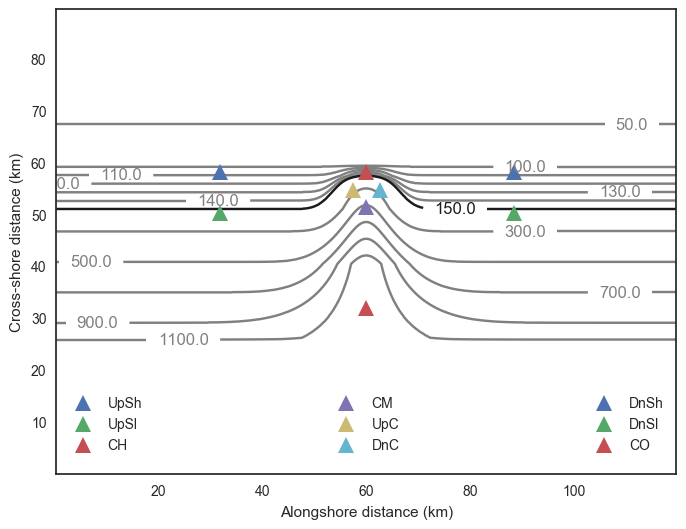

In [7]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

cntr = ax.contour(grid.X/1000,grid.Y/1000,grid.Depth,
                  [50,100,110,120,130,140,150,300,500,700,900,1100],
                  colors=['0.5','0.5','0.5','0.5','0.5','0.5','0.1','0.5','0.5','0.5','0.5','0.5','0.5'])
ax.clabel(cntr,fmt='%0.1f')

sns.set_palette('Paired',9)
for x,y,stn_name in zip(xs,ys,station_names):
    ax.plot(grid.X[x]/1000,grid.Y[y]/1000,'^',markersize=12,label=stn_name)

ax.legend(bbox_to_anchor=(0., 0.02, 1., .102), loc=8,ncol=3, mode="expand")
ax.set_xlabel('Alongshore distance (km)')
ax.set_ylabel('Cross-shore distance (km)')

<xarray.DataArray 'Z' ()>
array(-112.5)
Coordinates:
    Z        float64 -112.5
Attributes:
    long_name: vertical coordinate of cell center
    units: meters
    positive: up


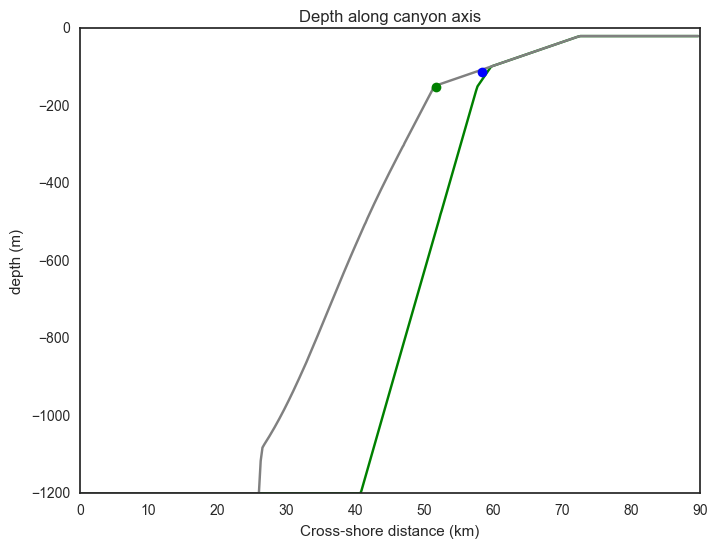

In [8]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax.plot(grid.YC[:,180]/1000,-grid.Depth[:,180],'g-')
ax.plot(grid.YC[:,100]/1000,-grid.Depth[:,100],'-',color='grey')
ax.plot(grid.YC[227,100]/1000,grid.Z[30],'go')  
ax.plot(grid.YC[262,100]/1000,grid.Z[22],'bo')  
ax.set_title('Depth along canyon axis')
ax.set_ylabel('depth (m)')
ax.set_xlabel('Cross-shore distance (km)')

print(grid.Z[22])

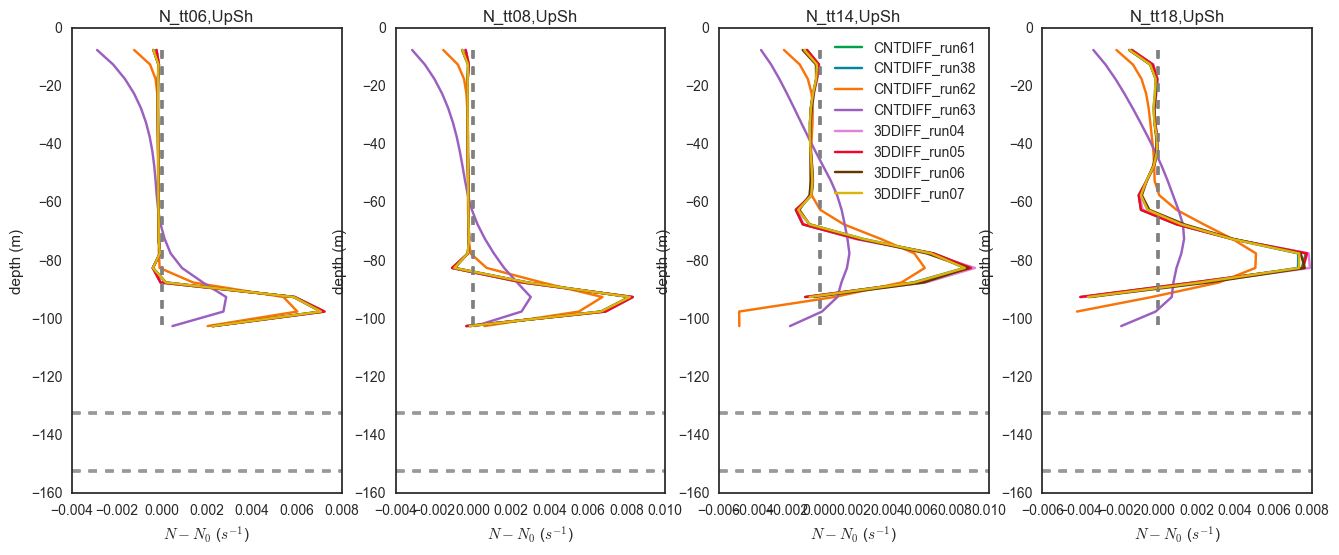

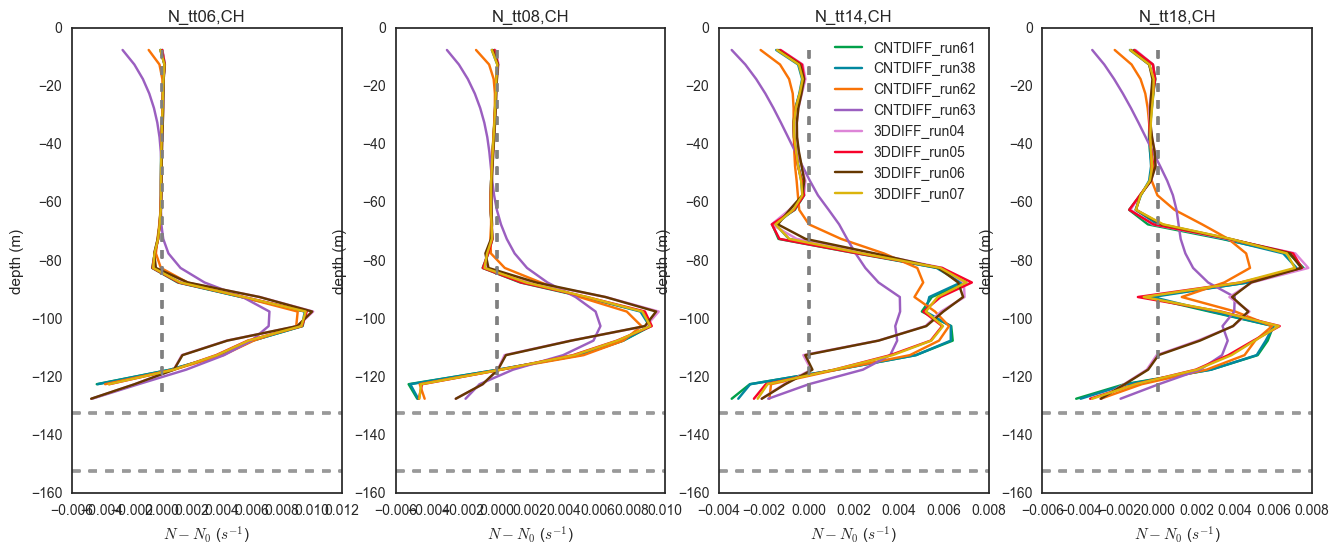

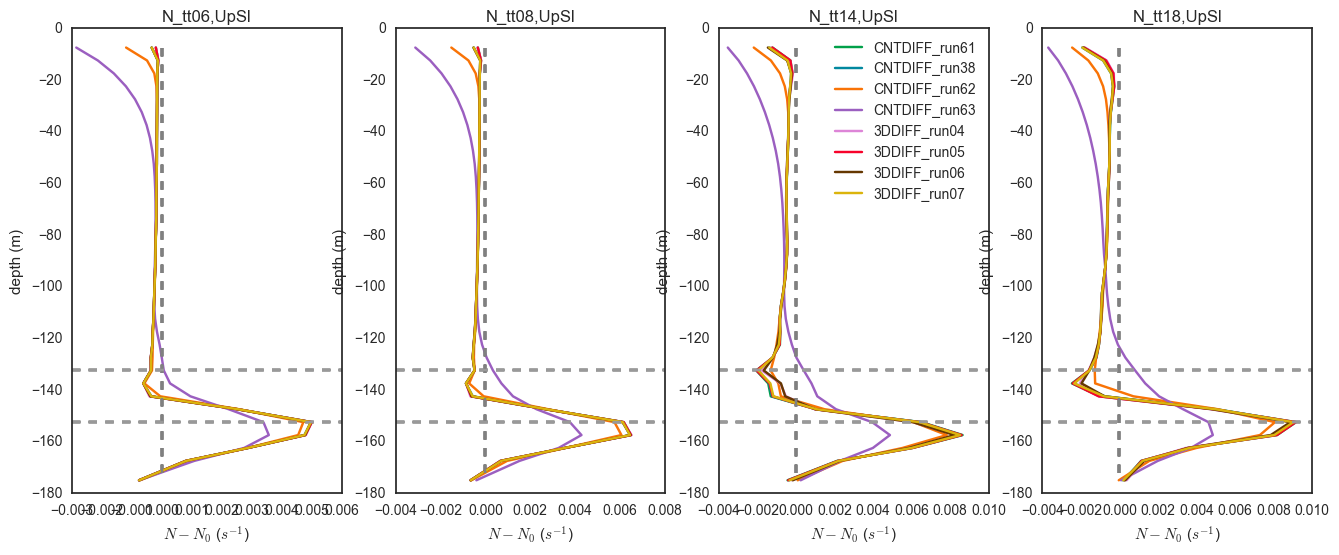

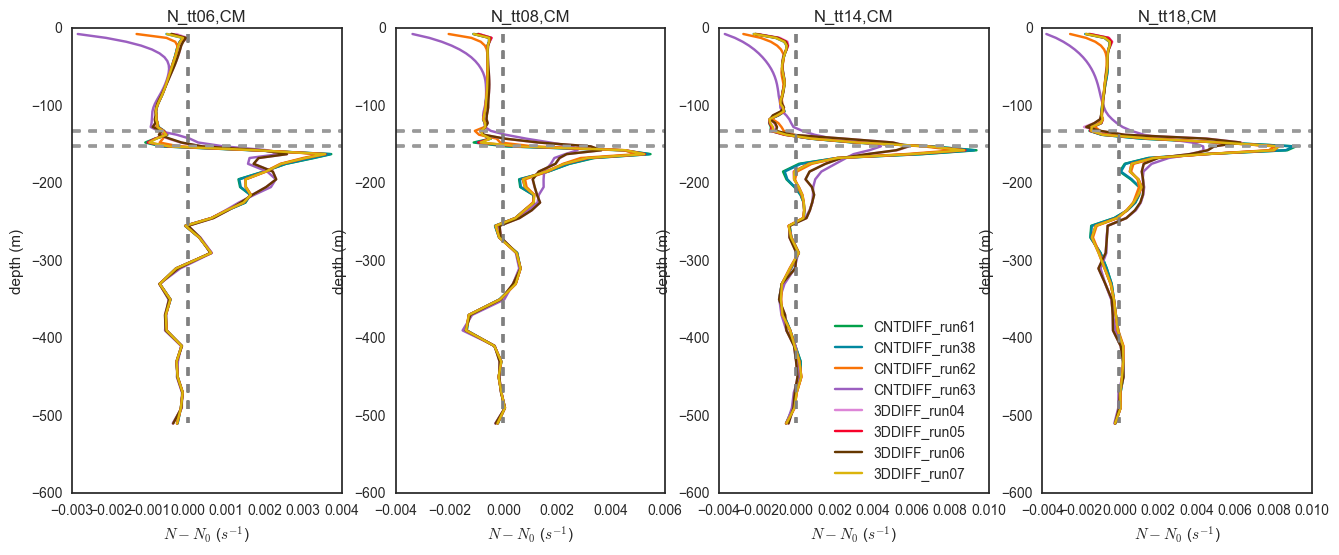

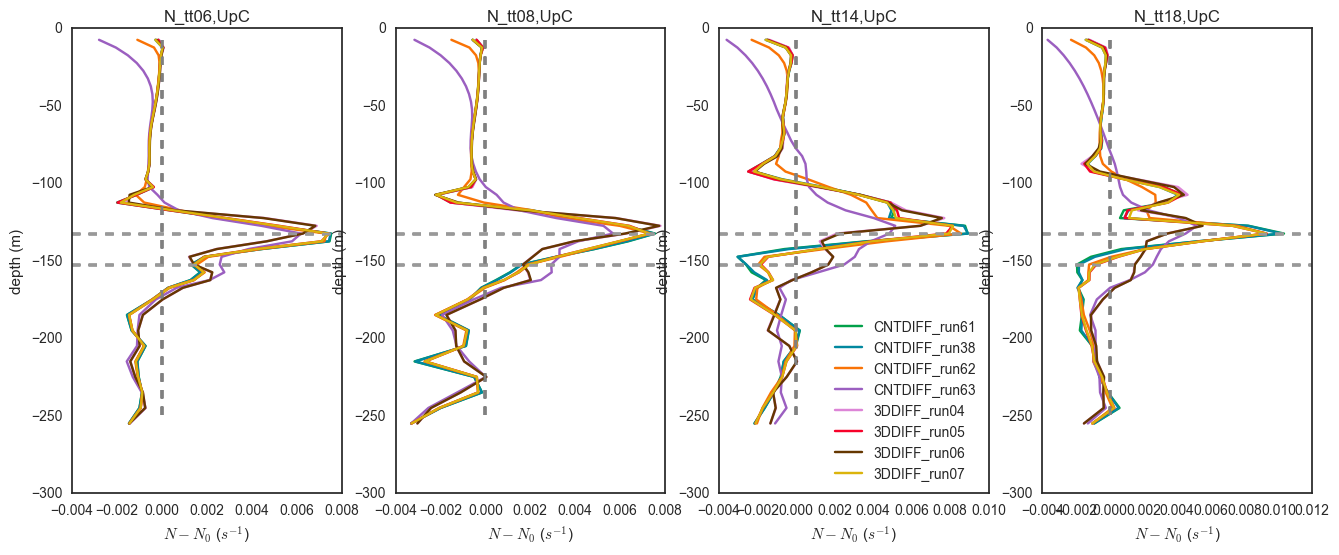

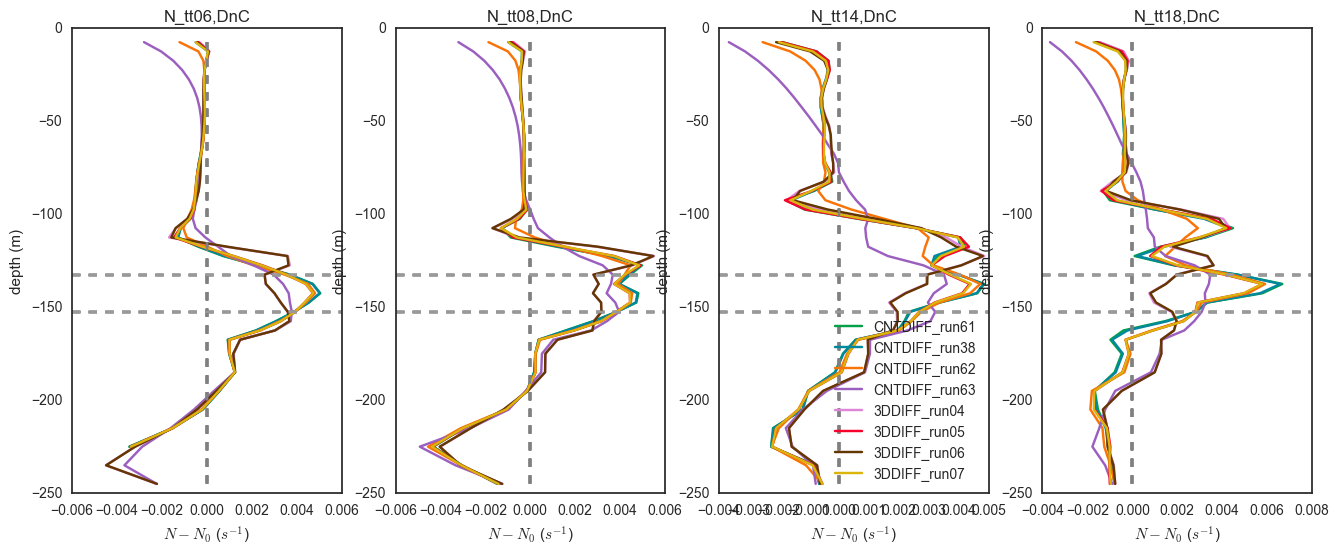

In [116]:
stationsCanyon = ['UpSh','CH','UpSl','CM','UpC','DnC']

expNames = ['CNTDIFF_run61',
           'CNTDIFF_run38',
           'CNTDIFF_run62',
           'CNTDIFF_run63',
           '3DDIFF_run04',
           '3DDIFF_run05',
           '3DDIFF_run06',
           '3DDIFF_run07']


colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst",# 
          "lavender pink",
          "cherry red",
          "brown",
          "gold"]# 

colour_pal = sns.xkcd_palette(colours)

for stname in stationsCanyon:
    
    figHand = plotN2(stname,expNames,colour_pal)
    #figName = ('results/figures/BuoyancyFrequency/N2_Kv3D_%s.png' %stname)
    #figHand.savefig(figName,format='png')

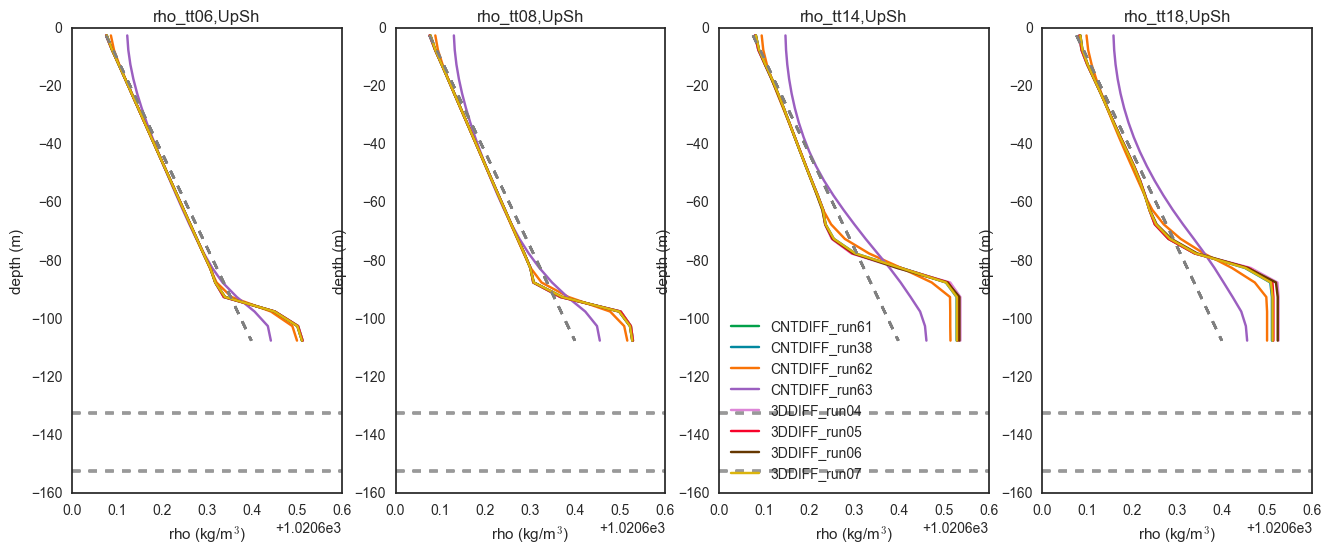

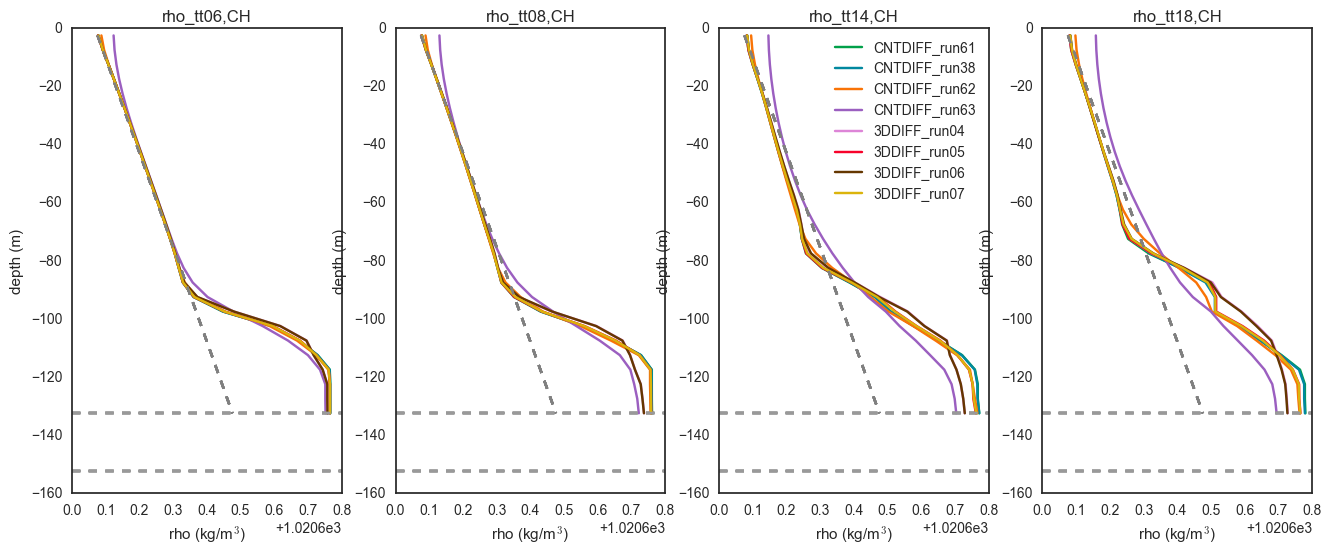

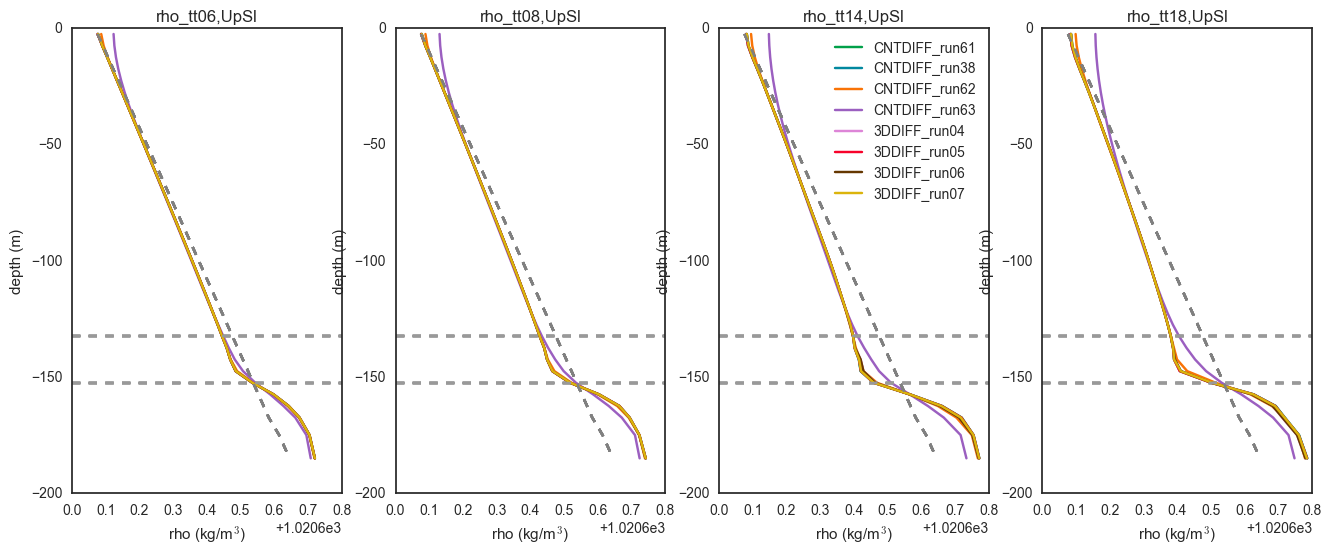

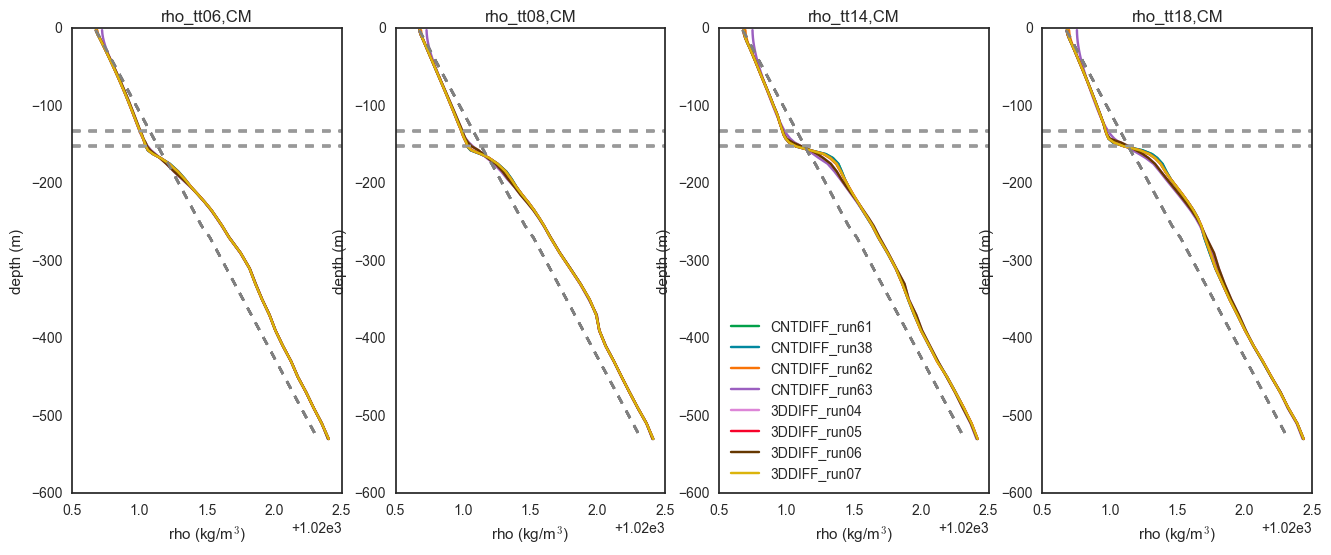

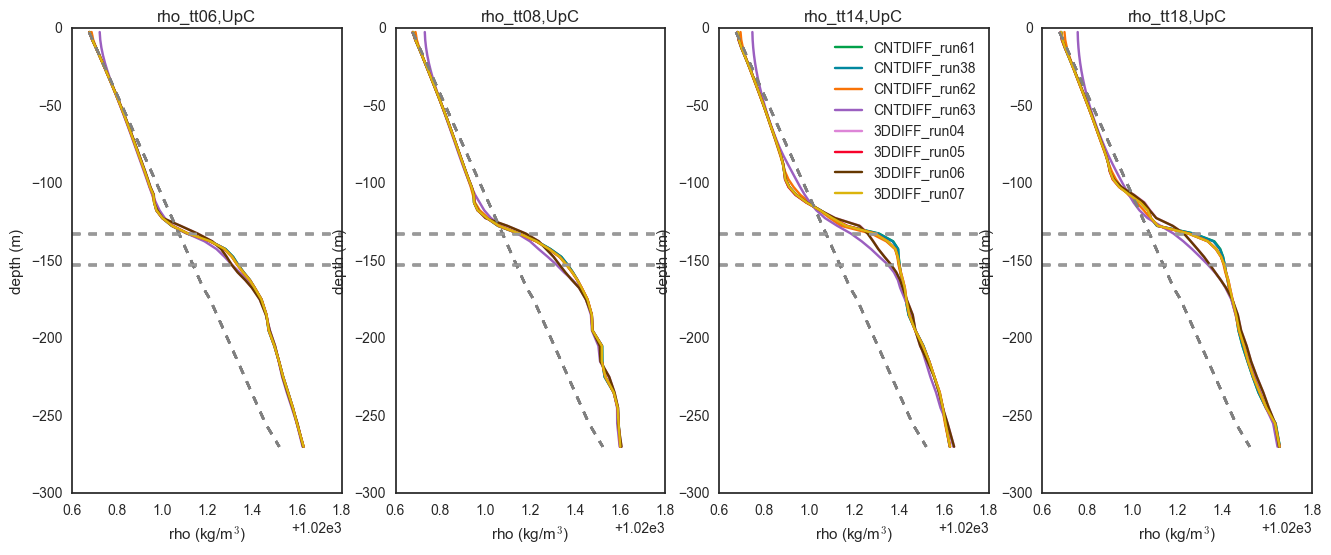

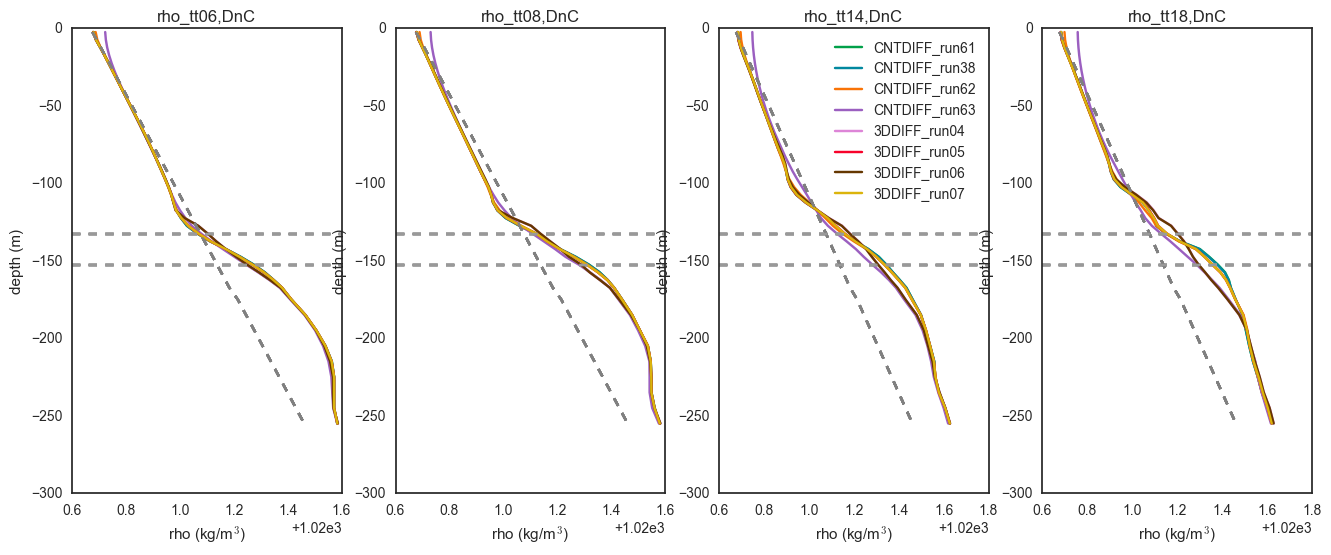

In [10]:
stationsCanyon = ['UpSh','CH','UpSl','CM','UpC','DnC']

expNames = ['CNTDIFF_run61',
           'CNTDIFF_run38',
           'CNTDIFF_run62',
           'CNTDIFF_run63',
           '3DDIFF_run04',
           '3DDIFF_run05',
           '3DDIFF_run06',
           '3DDIFF_run07']


colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst",# 
          "lavender pink",
          "cherry red",
          "brown",
          "gold"]# 

colour_pal = sns.xkcd_palette(colours)

for stname in stationsCanyon:
    
    figHand = plotRhoProfile(stname,expNames,colour_pal)
    #figName = ('results/figures/BuoyancyFrequency/N2_Kv3D_%s.png' %stname)
    #figHand.savefig(figName,format='png')


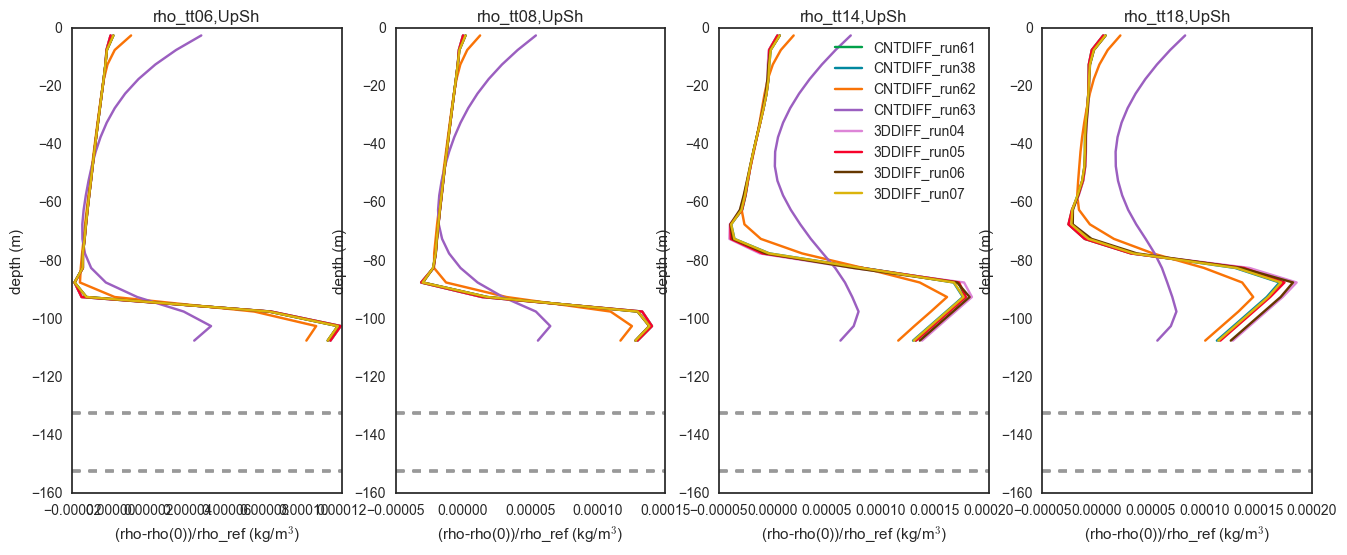

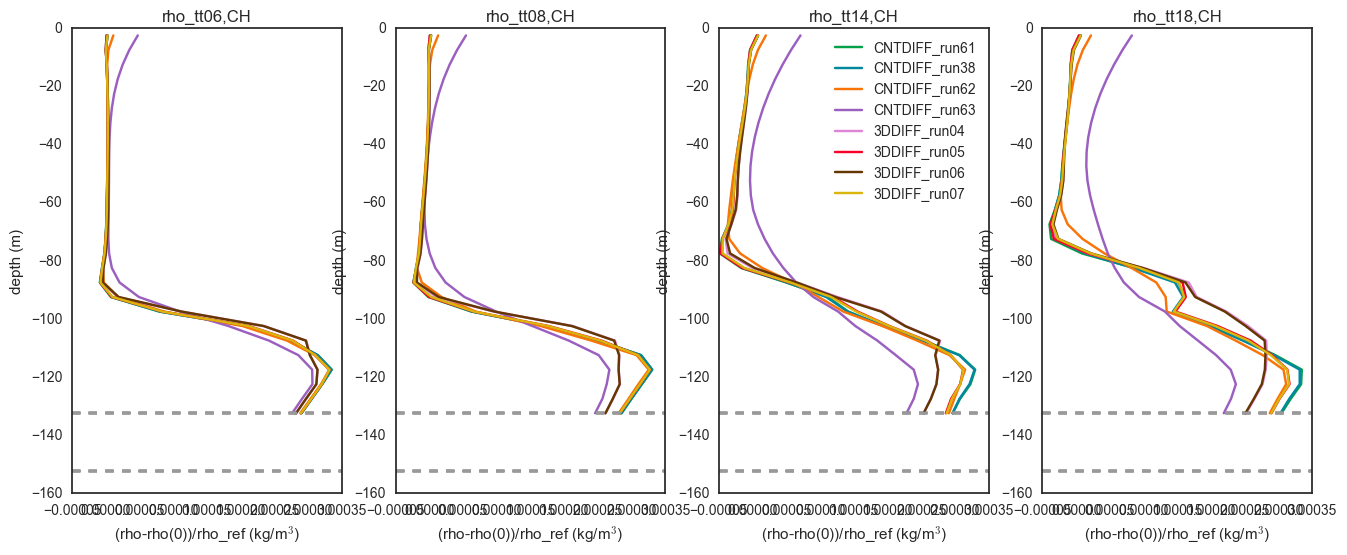

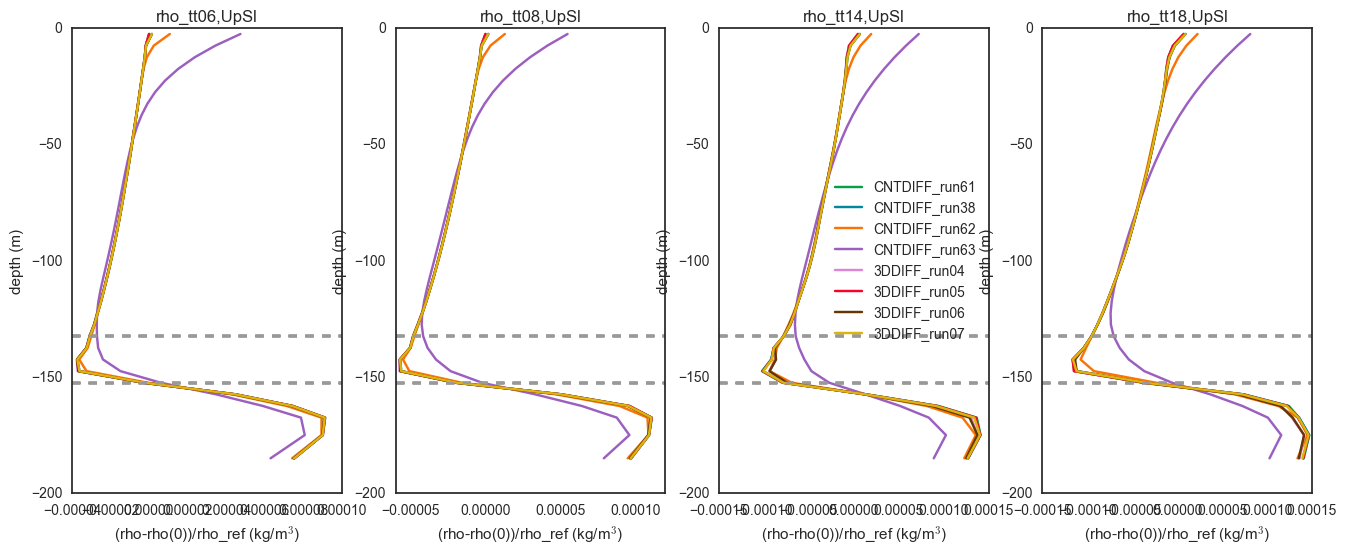

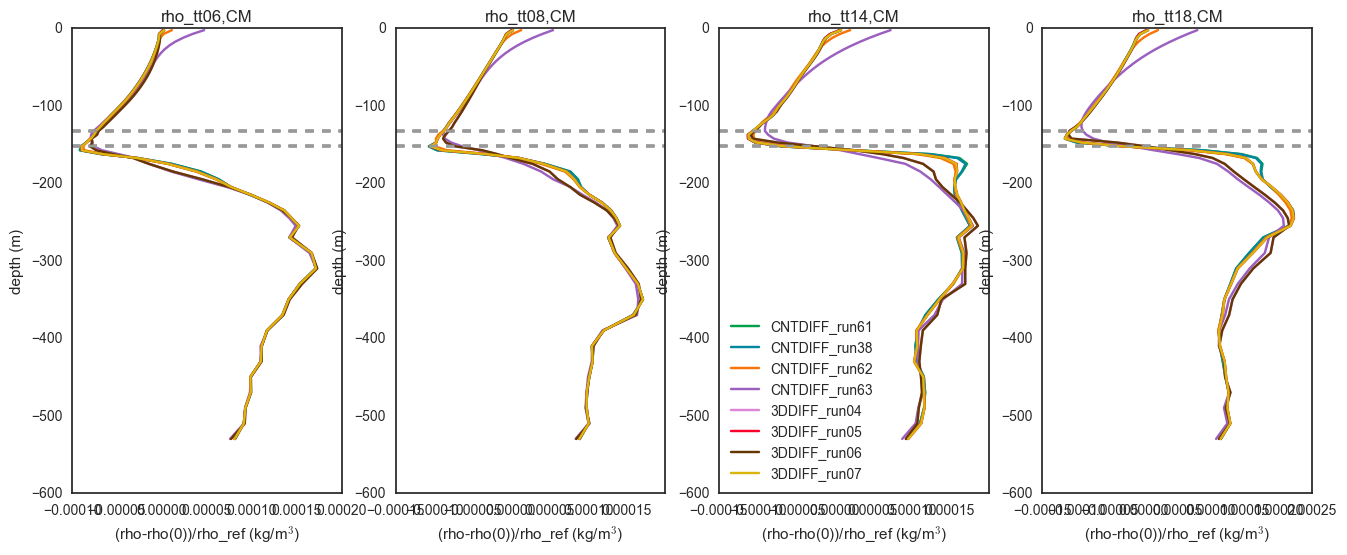

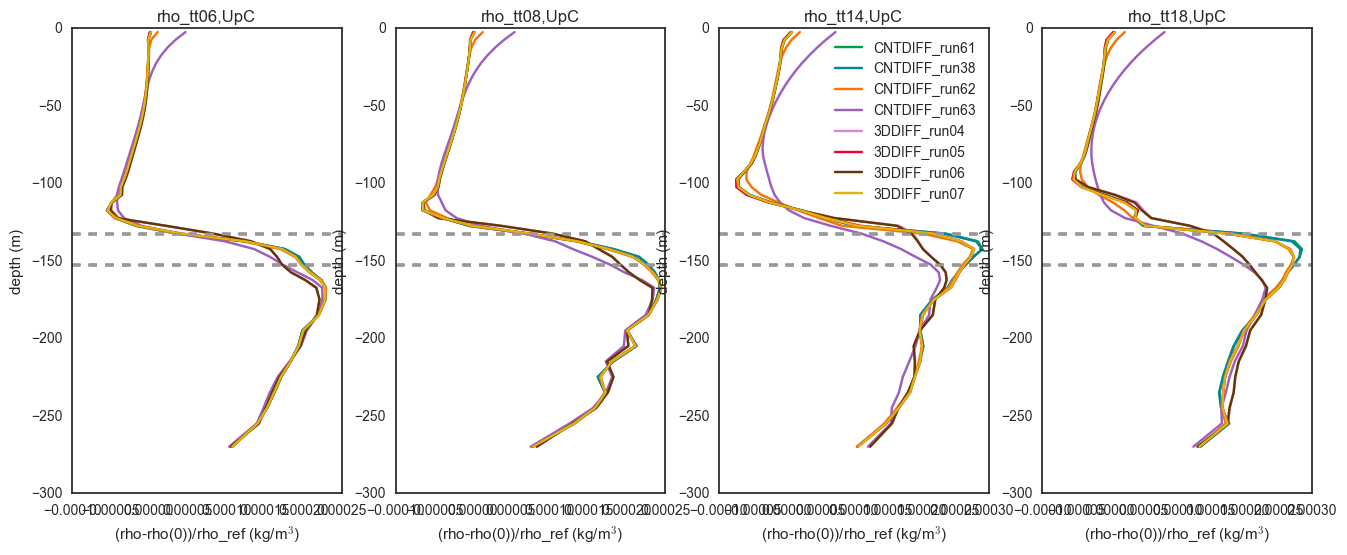

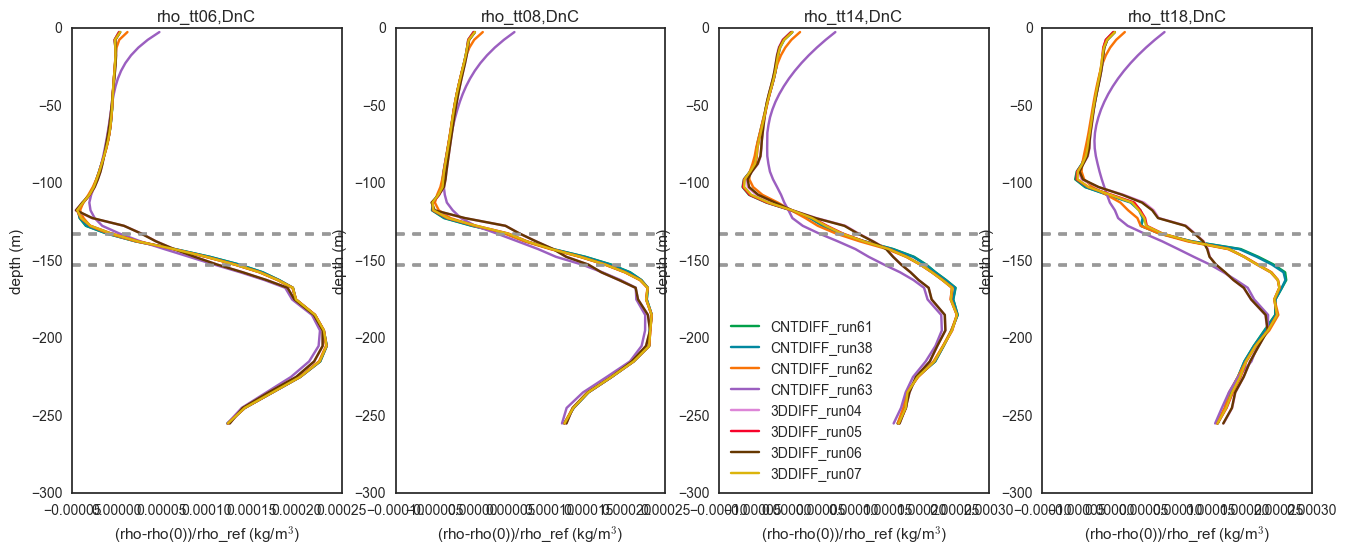

In [11]:
stationsCanyon = ['UpSh','CH','UpSl','CM','UpC','DnC']

expNames = ['CNTDIFF_run61',
           'CNTDIFF_run38',
           'CNTDIFF_run62',
           'CNTDIFF_run63',
           '3DDIFF_run04',
           '3DDIFF_run05',
           '3DDIFF_run06',
           '3DDIFF_run07']


colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst",# 
          "lavender pink",
          "cherry red",
          "brown",
          "gold"]# 

colour_pal = sns.xkcd_palette(colours)

for stname in stationsCanyon:
    
    figHand = plotDRhoRho0(stname,expNames,colour_pal)
    #figName = ('results/figures/BuoyancyFrequency/N2_Kv3D_%s.png' %stname)
    #figHand.savefig(figName,format='png')


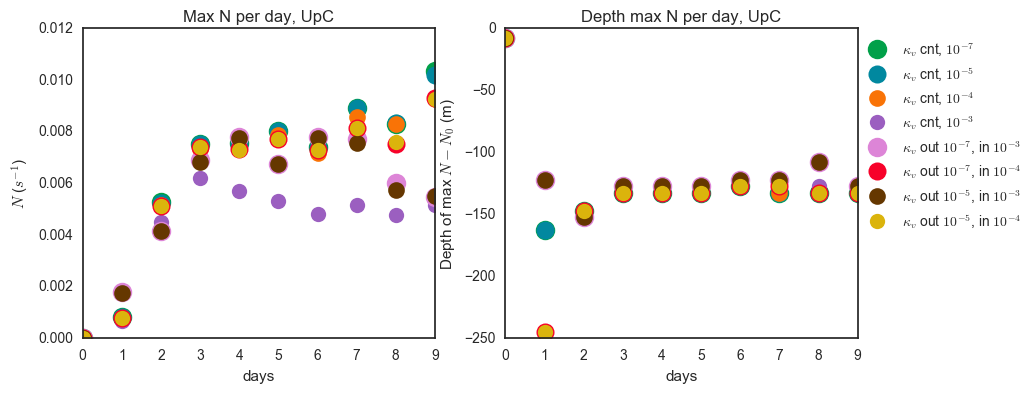

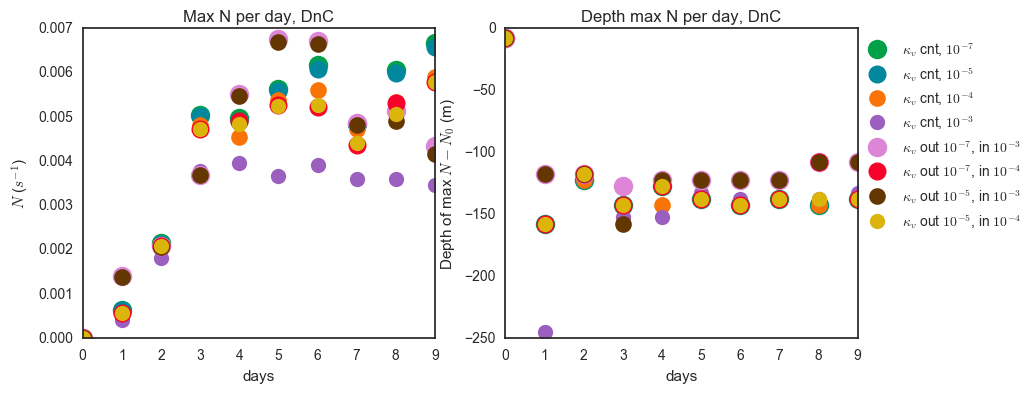

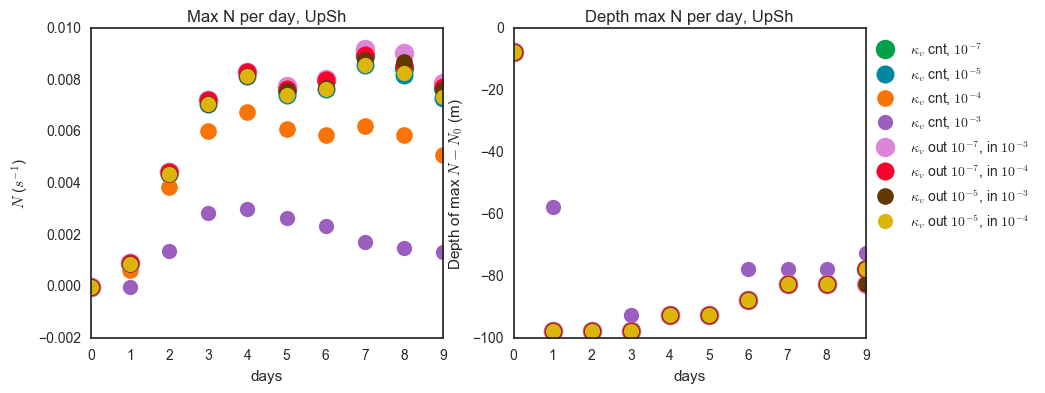

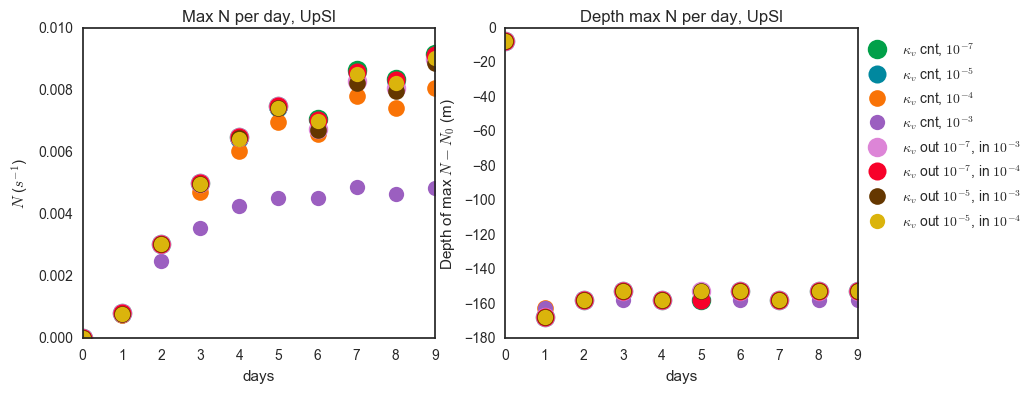

In [93]:
stationsCanyon = ['UpC','DnC','UpSh','UpSl']

expNames = ['CNTDIFF_run61',
           'CNTDIFF_run38',
           'CNTDIFF_run62',
           'CNTDIFF_run63',
           '3DDIFF_run04',
           '3DDIFF_run05',
           '3DDIFF_run06',
           '3DDIFF_run07']

kv_lab = ['$\kappa_v$ cnt, $10^{-7}$',
         '$\kappa_v$ cnt, $10^{-5}$',
         '$\kappa_v$ cnt, $10^{-4}$',
         '$\kappa_v$ cnt, $10^{-3}$',
         '$\kappa_v$ out $10^{-7}$, in $10^{-3}$',
         '$\kappa_v$ out $10^{-7}$, in $10^{-4}$',
         '$\kappa_v$ out $10^{-5}$, in $10^{-3}$',
         '$\kappa_v$ out $10^{-5}$, in $10^{-4}$']

colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst",# 
          "lavender pink",
          "cherry red",
          "brown",
          "gold"]# 

sizes = [14,13,12,11,14,13,12,11]
for stname in stationsCanyon:
    
    figHand = plotMax(stname,expNames,colours,sizes, kv_lab)
    
    
    #figName = ('results/figures/BuoyancyFrequency/N2_Kv3D_%s.png' %stname)
    #figHand.savefig(figName,format='png')

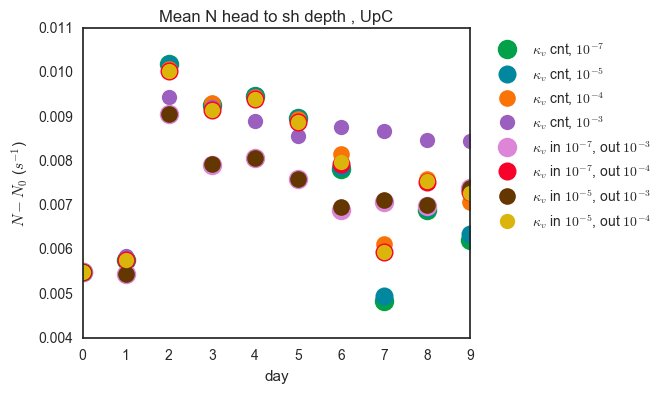

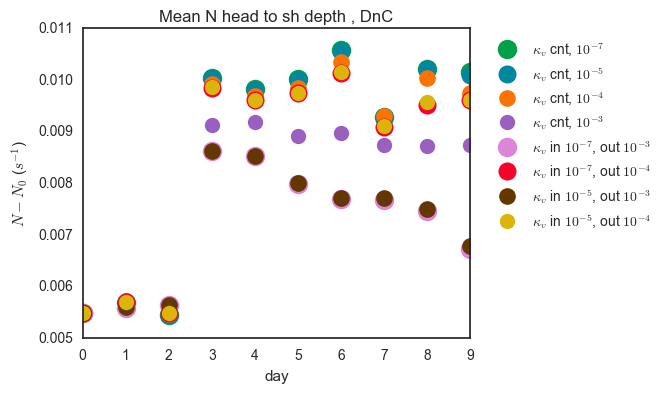

In [33]:
stationsCanyon = ['UpC','DnC']

expNames = ['CNTDIFF_run61',
           'CNTDIFF_run38',
           'CNTDIFF_run62',
           'CNTDIFF_run63',
           '3DDIFF_run04',
           '3DDIFF_run05',
           '3DDIFF_run06',
           '3DDIFF_run07']

kv_lab = ['$\kappa_v$ cnt, $10^{-7}$',
         '$\kappa_v$ cnt, $10^{-5}$',
         '$\kappa_v$ cnt, $10^{-4}$',
         '$\kappa_v$ cnt, $10^{-3}$',
         '$\kappa_v$ in $10^{-7}$, out $10^{-3}$',
         '$\kappa_v$ in $10^{-7}$, out $10^{-4}$',
         '$\kappa_v$ in $10^{-5}$, out $10^{-3}$',
         '$\kappa_v$ in $10^{-5}$, out $10^{-4}$']

colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst",# 
          "lavender pink",
          "cherry red",
          "brown",
          "gold"]# 

sizes = [14,13,12,11,14,13,12,11]
for stname in stationsCanyon:
    
    figHand = plotN_atDepth(stname,expNames,colours,sizes, kv_lab,26,30)
    
    
    #figName = ('results/figures/BuoyancyFrequency/N2_Kv3D_%s.png' %stname)
    #figHand.savefig(figName,format='png')

### Compare to runs where N is changing

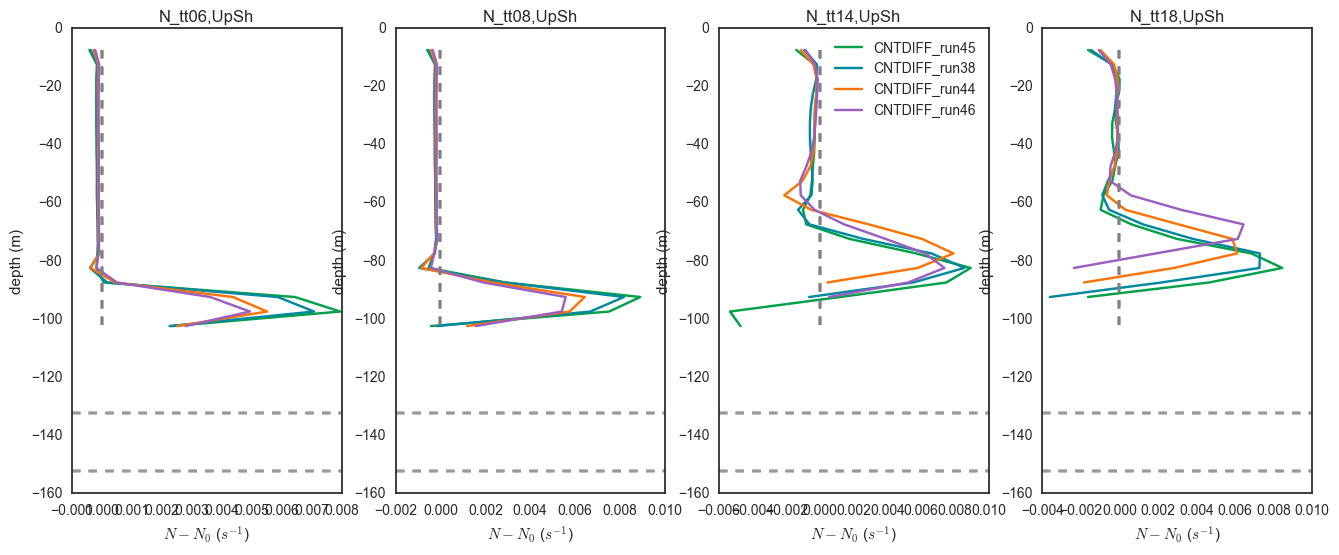

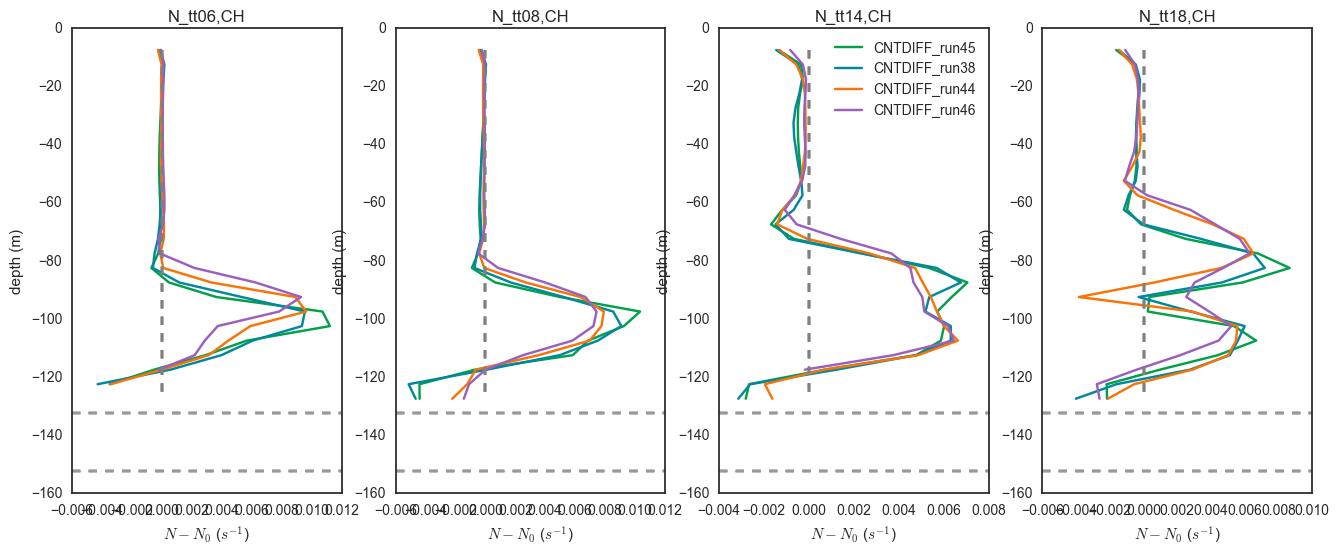

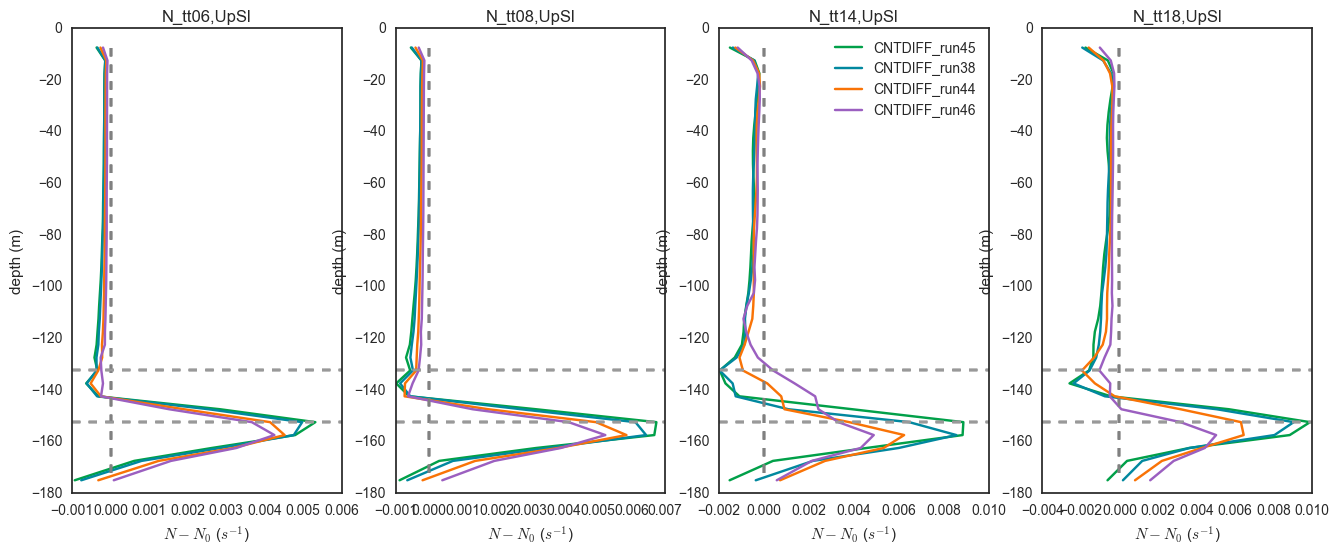

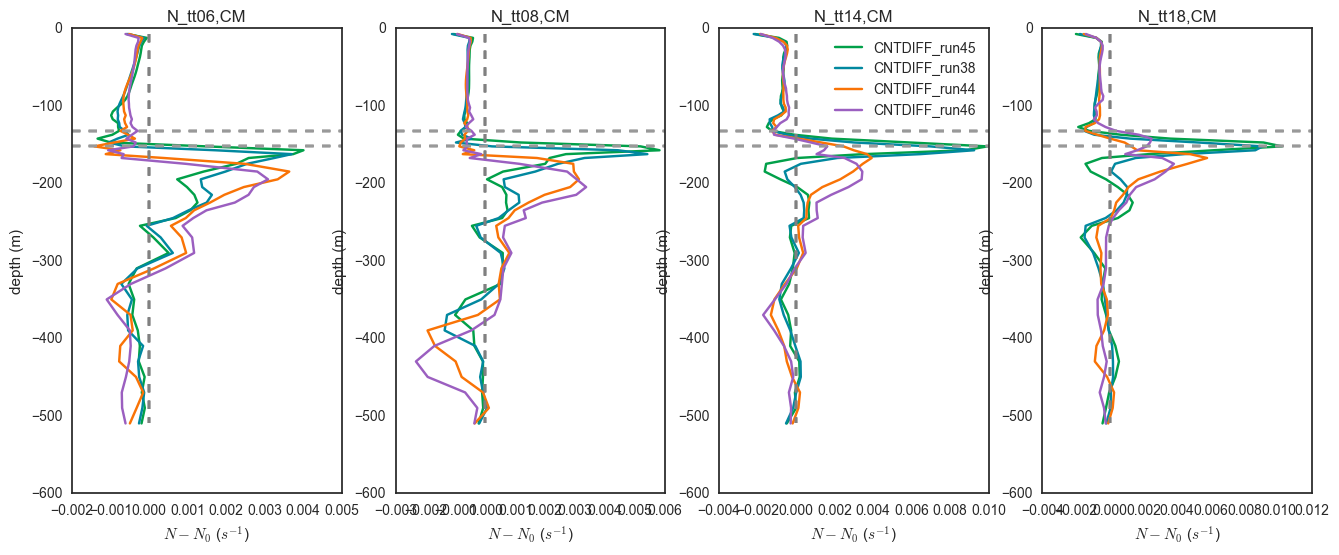

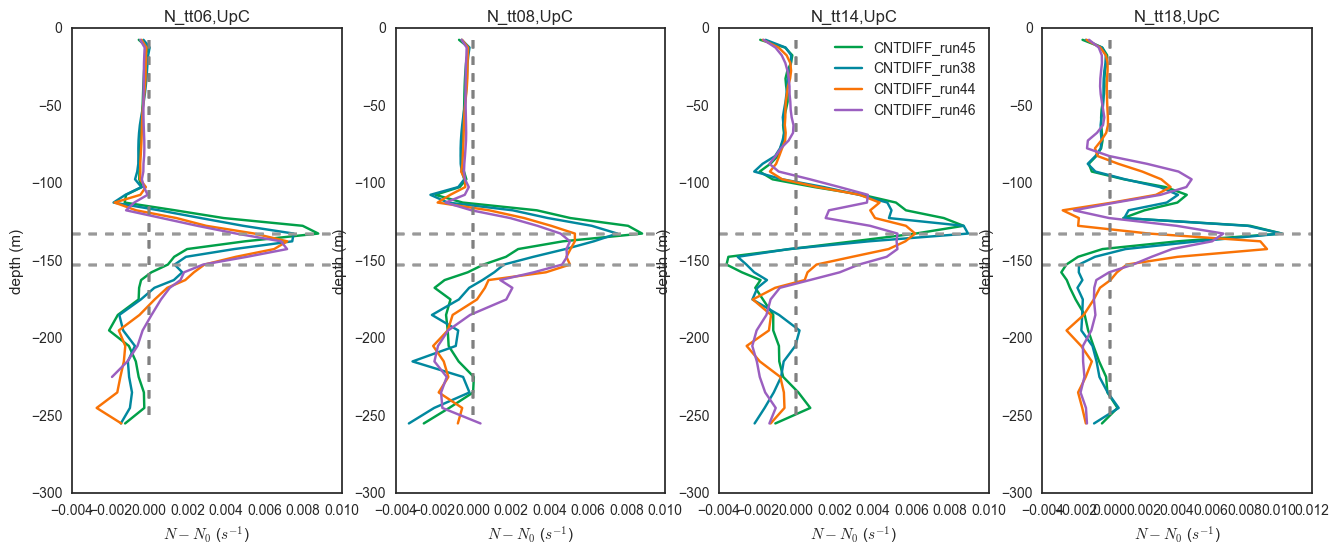

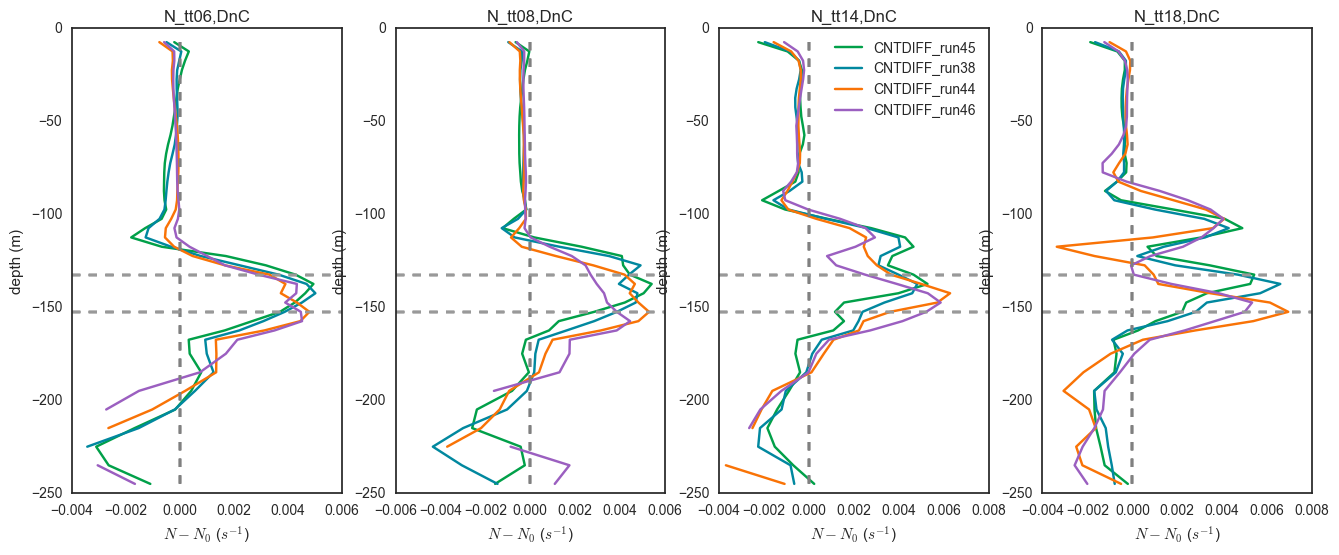

In [14]:
stationsCanyon = ['UpSh','CH','UpSl','CM','UpC','DnC']

expNames = ['CNTDIFF_run45',
           'CNTDIFF_run38',
           'CNTDIFF_run44',
           'CNTDIFF_run46',
           ]

kv_lab = ['$N_0$ 6.0x10$^-3$',
         '$N_0$ 5.5x10$^-3$',
         '$N_0$ 3.9x10$^-3$',
         '$N_0$ 3.0x10$^-3$',
         ]

colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst"]# 


colour_pal = sns.xkcd_palette(colours)

for stname in stationsCanyon:
    
    figHand = plotN2(stname,expNames,colour_pal)
    #figName = ('results/figures/BuoyancyFrequency/N2_Kv3D_%s.png' %stname)
    #figHand.savefig(figName,format='png')
    

    
#figHand1 = plotN2_CanyonAnom('CM','UpSl',expNames,colour_pal)
#figHand2 = plotN2_CanyonAnom('CH','UpSh',expNames,colour_pal)


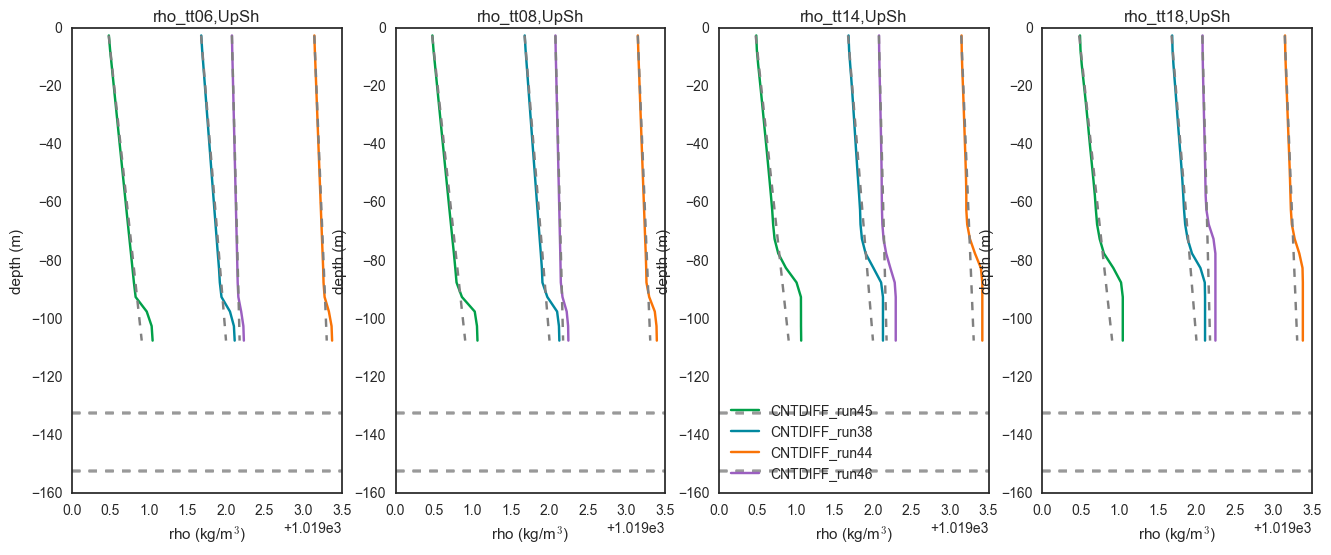

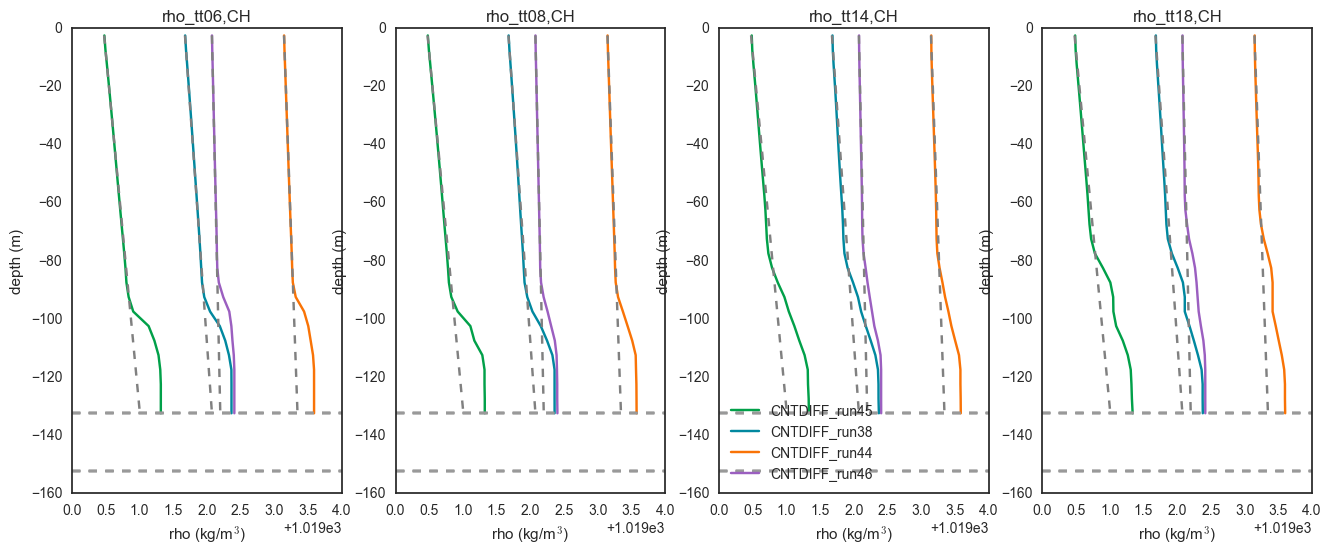

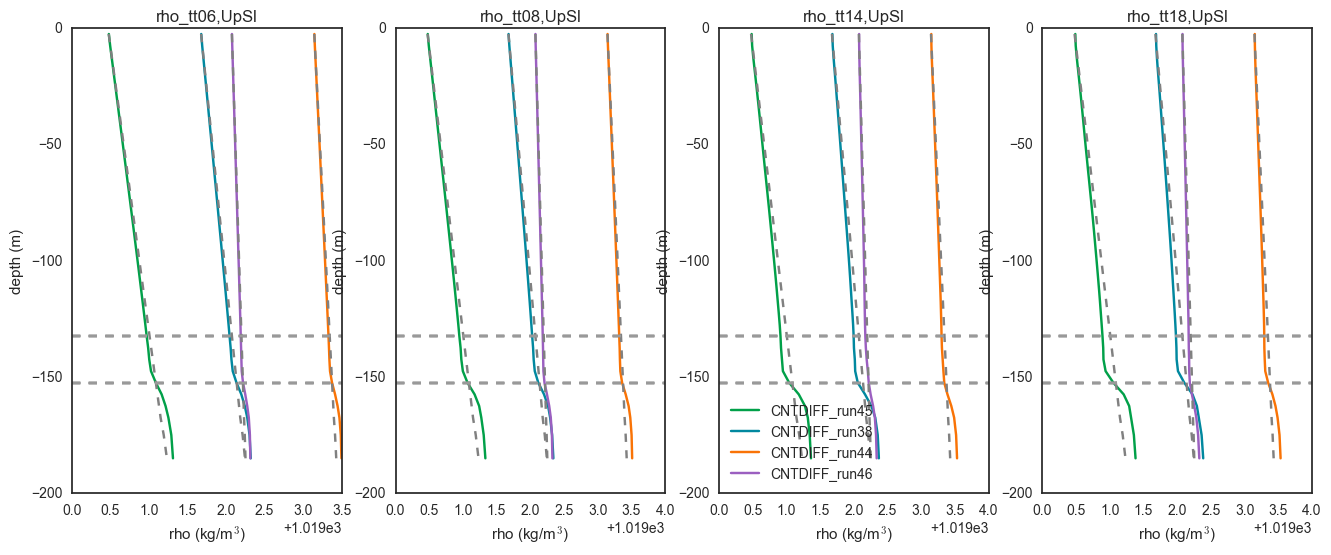

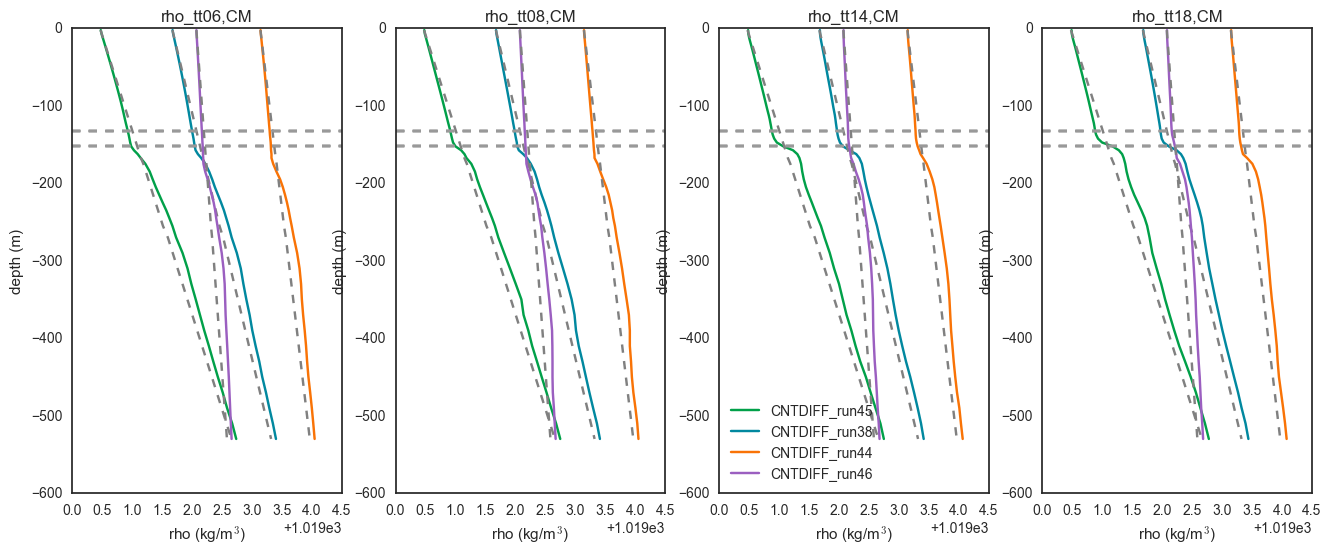

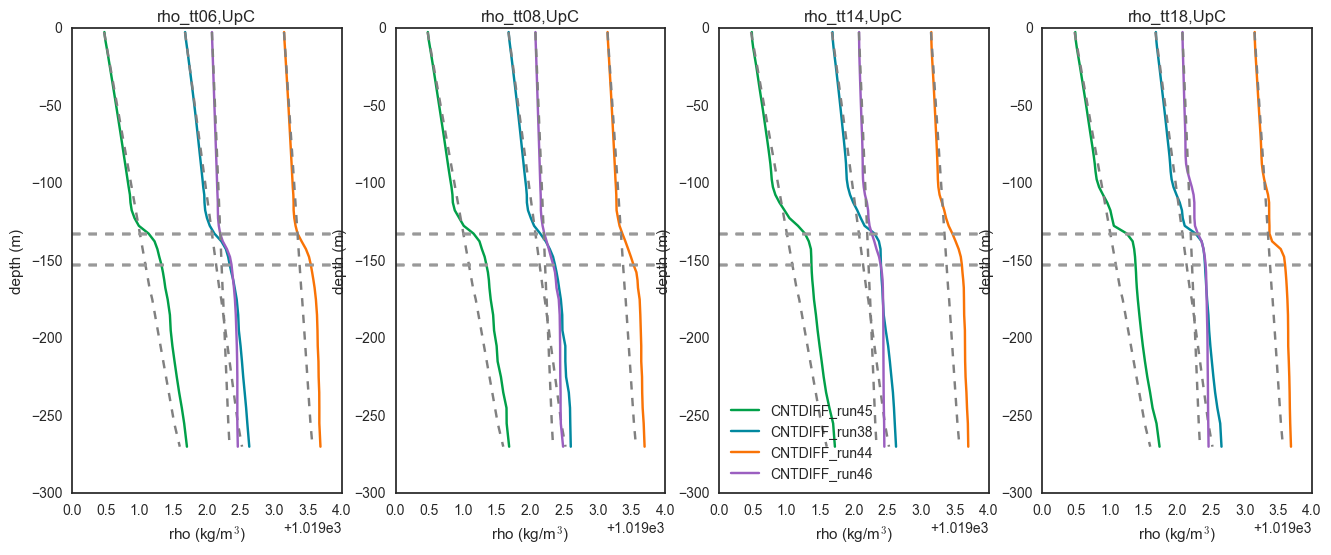

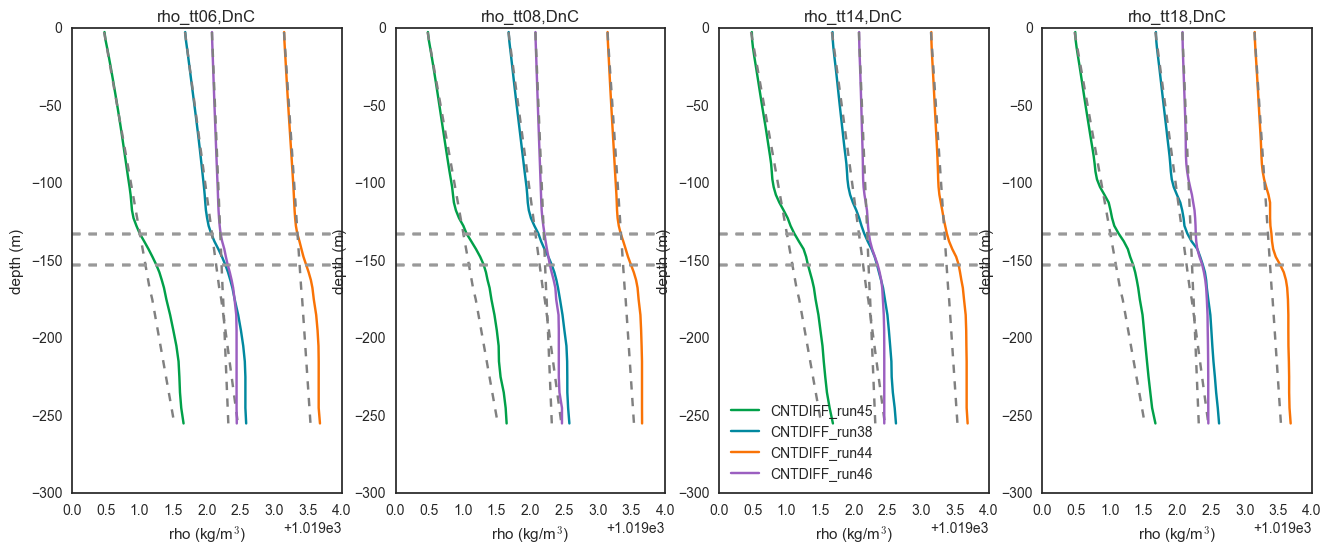

In [15]:
stationsCanyon = ['UpSh','CH','UpSl','CM','UpC','DnC']

expNames = ['CNTDIFF_run45',
           'CNTDIFF_run38',
           'CNTDIFF_run44',
           'CNTDIFF_run46',
           ]

kv_lab = ['$N_0$ 6.0x10$^-3$',
         '$N_0$ 5.5x10$^-3$',
         '$N_0$ 3.9x10$^-3$',
         '$N_0$ 3.0x10$^-3$',
         ]

colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst"]# 


colour_pal = sns.xkcd_palette(colours)

for stname in stationsCanyon:
    
    figHand = plotRhoProfile(stname,expNames,colour_pal)
    #figName = ('results/figures/BuoyancyFrequency/N2_Kv3D_%s.png' %stname)
    #figHand.savefig(figName,format='png')
    

    
#figHand1 = plotN2_CanyonAnom('CM','UpSl',expNames,colour_pal)
#figHand2 = plotN2_CanyonAnom('CH','UpSh',expNames,colour_pal)


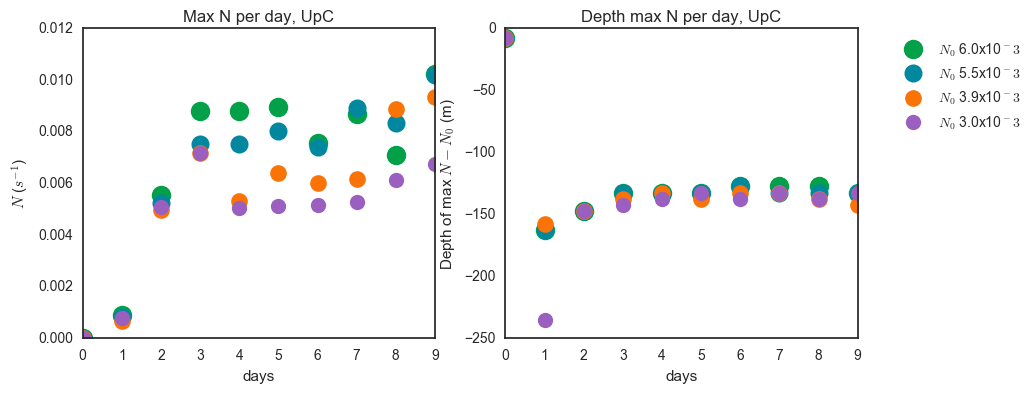

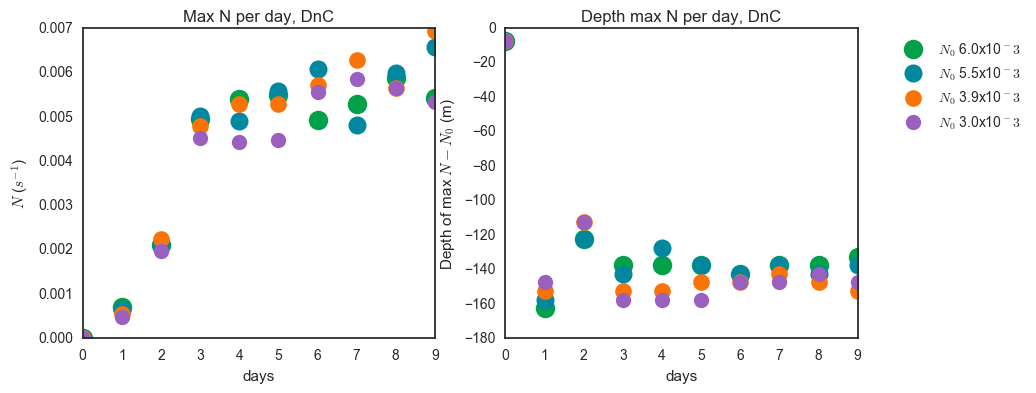

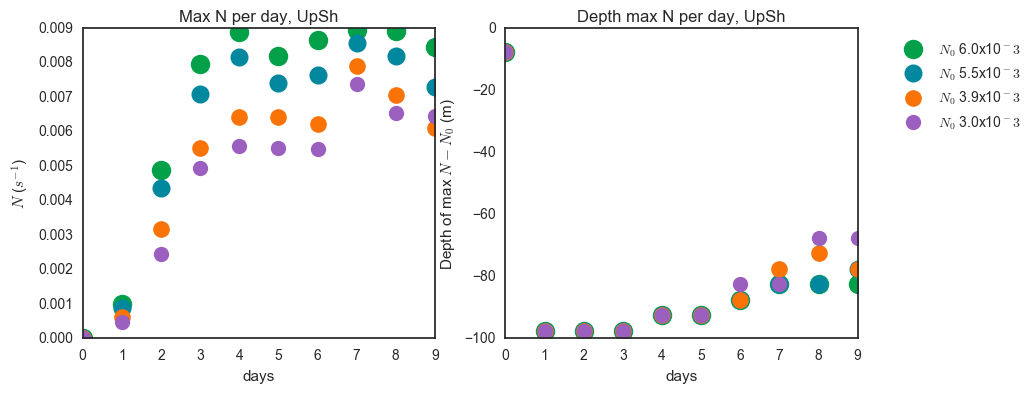

In [32]:
stationsCanyon = ['UpC','DnC','UpSh']

expNames = ['CNTDIFF_run45',
           'CNTDIFF_run38',
           'CNTDIFF_run44',
           'CNTDIFF_run46',
           ]

kv_lab = ['$N_0$ 6.0x10$^-3$',
         '$N_0$ 5.5x10$^-3$',
         '$N_0$ 3.9x10$^-3$',
         '$N_0$ 3.0x10$^-3$',
         ]

colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst"]# 

sizes = [14,13,12,11]
for stname in stationsCanyon:
    
    figHand = plotMax(stname,expNames,colours,sizes, kv_lab)
    
    
    #figName = ('results/figures/BuoyancyFrequency/N2_Kv3D_%s.png' %stname)
    #figHand.savefig(figName,format='png')

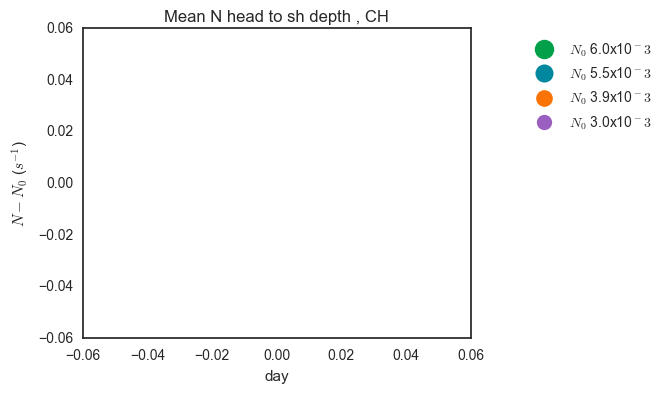

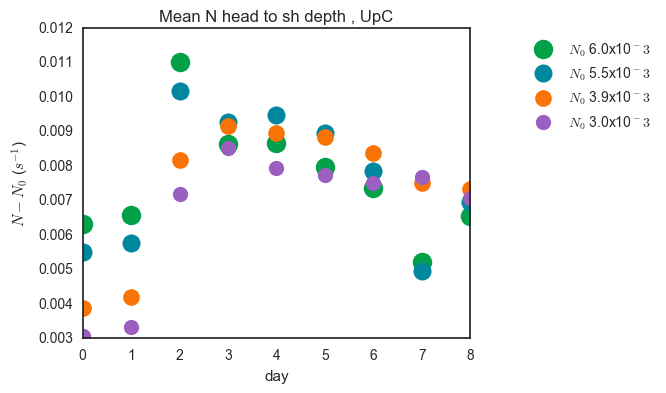

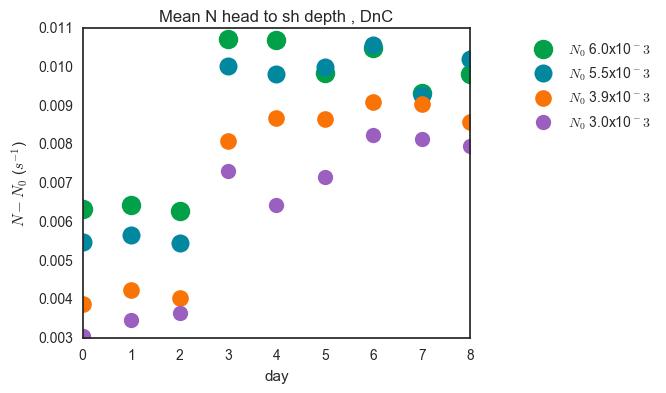

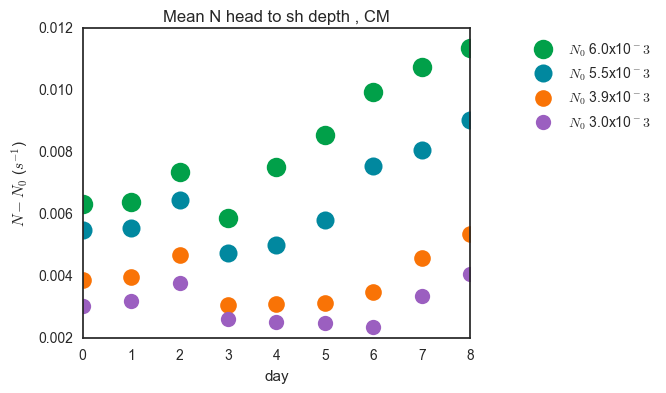

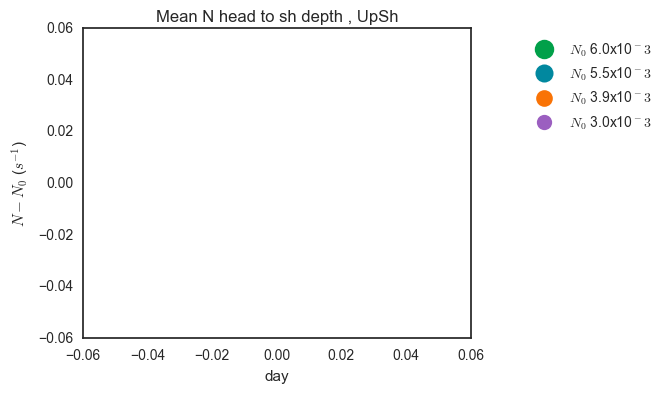

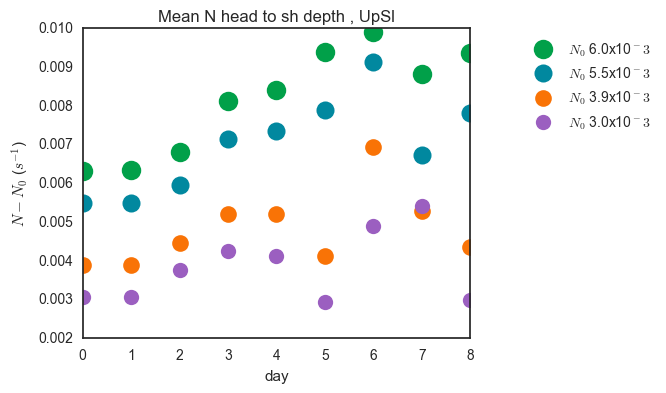

In [17]:
stationsCanyon = ['UpC','DnC']

expNames = ['CNTDIFF_run45',
           'CNTDIFF_run38',
           'CNTDIFF_run44',
           'CNTDIFF_run46',
           ]

kv_lab = ['$N_0$ 6.0x10$^-3$',
         '$N_0$ 5.5x10$^-3$',
         '$N_0$ 3.9x10$^-3$',
         '$N_0$ 3.0x10$^-3$',
         ]

colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst"]# 

sizes = [14,13,12,11]
for stname in stationsCanyon:
    
    figHand = plotN_atDepth(stname,expNames,colours,sizes, kv_lab,26,30)


### Plot the effective $N_0$ I proposed above

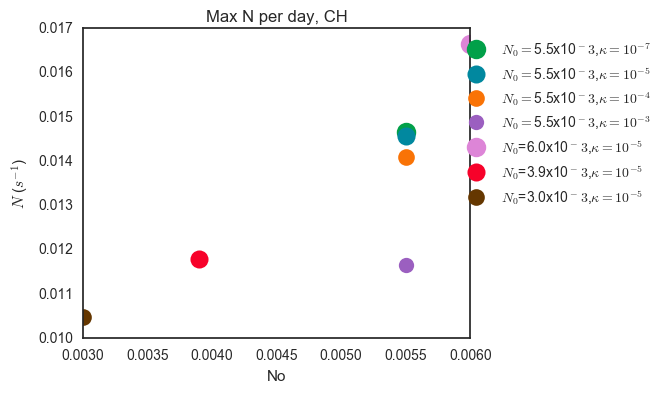

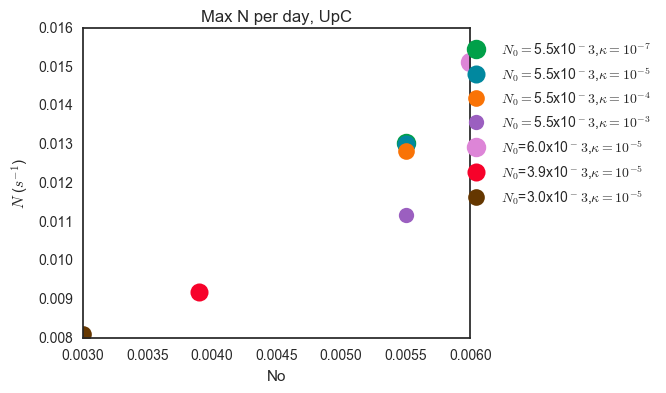

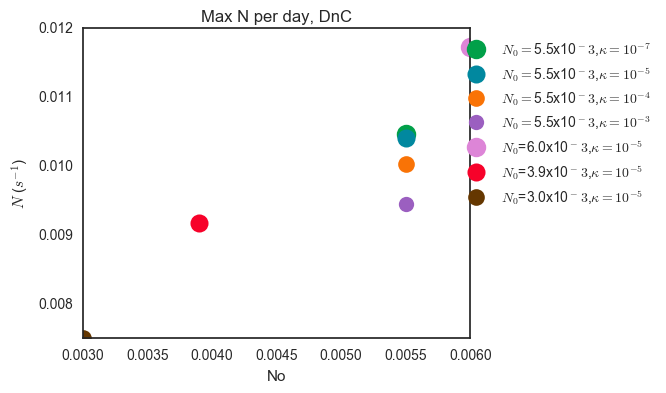

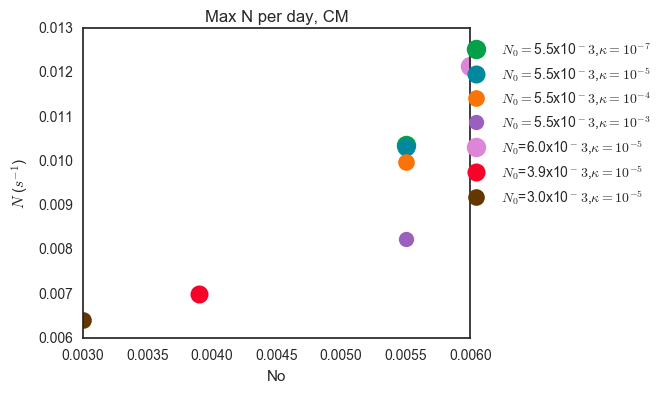

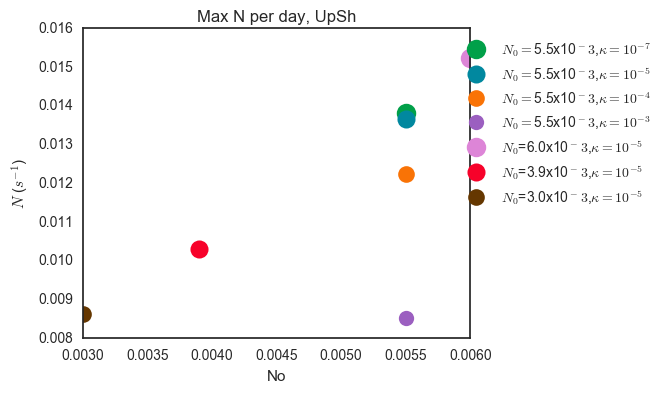

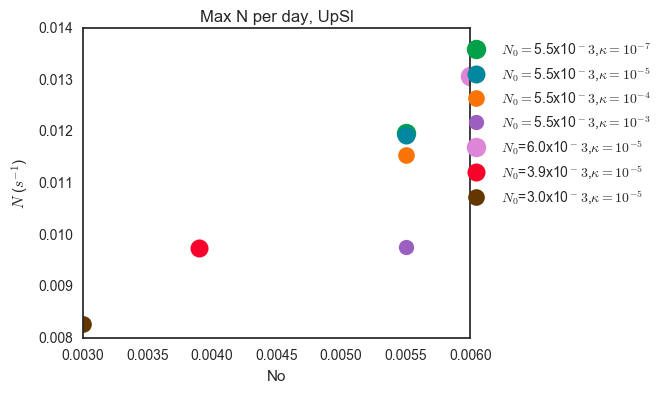

In [29]:
kv = np.array([1E-7,1E-5,1E-4,1E-3,1E-5,1E-5,1E-5,])
No = np.array([5.5E-3,5.5E-3,5.5E-3,5.5E-3,6E-3,3.9E-3,3E-3,])

No_scale = (No*1.4*0.36)/(9.66E-5*(5000*6400)**(1/2))
#No_scale = 1.4 N U / f (Rupstream L)**(1/2)

dz = 10 # m
tau = (dz**2)/(kv)
t_adv = 4*3600*24 # 4 days * 24 hrs * 3600 s



Neff = No_scale*(tau-t_adv)/tau

#plot Neff vs N at day 4

stationsCanyon = ['CH','UpC','DnC','CM','UpSh','UpSl']

expNames = ['CNTDIFF_run61',
            'CNTDIFF_run38',
            'CNTDIFF_run62',
            'CNTDIFF_run63',
            'CNTDIFF_run45',
            'CNTDIFF_run44',
            'CNTDIFF_run46',
           ]
          

kv_lab = ['$N_0=$5.5x10$^-3$,$\kappa=10^{-7}$',
         '$N_0=$5.5x10$^-3$,$\kappa=10^{-5}$',
         '$N_0=$5.5x10$^-3$,$\kappa=10^{-4}$',
         '$N_0=$5.5x10$^-3$,$\kappa=10^{-3}$',
         '$N_0$=6.0x10$^-3$,$\kappa=10^{-5}$',
         '$N_0$=3.9x10$^-3$,$\kappa=10^{-5}$',
         '$N_0$=3.0x10$^-3$,$\kappa=10^{-5}$',
         ]

colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst",# 
          "lavender pink",
          "cherry red",
          "brown",
          "gold"]# 

sizes = [14,13,12,11,14,13,12,11]

for stname in stationsCanyon:
    
    figHand = plotN_eff(stname,expNames,colours,sizes, kv_lab,26,90,No,'N_tt08','No')


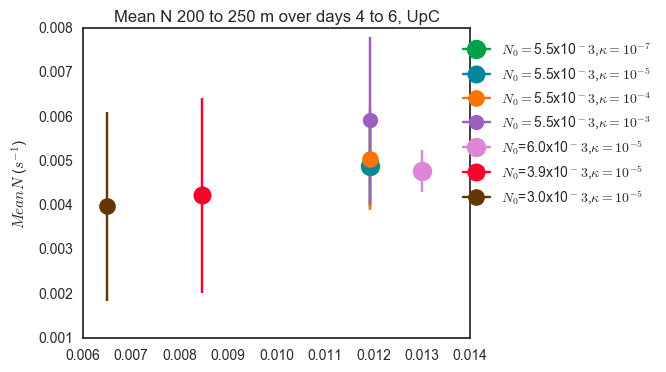

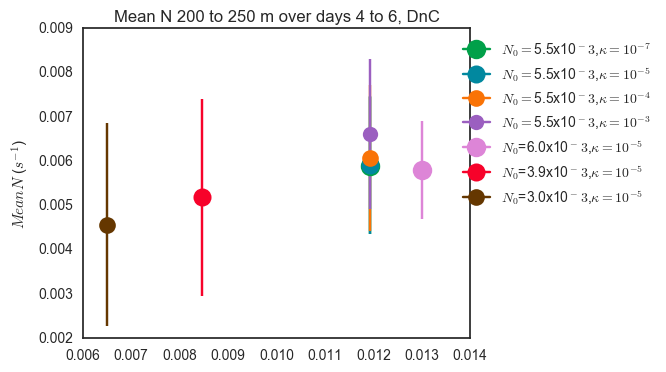

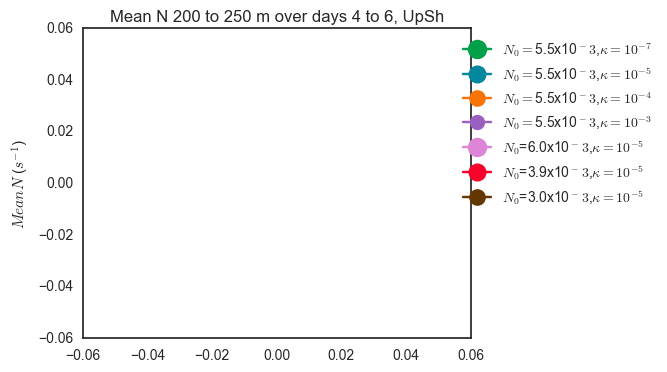

In [115]:
kv = np.array([1E-7,1E-5,1E-4,1E-3,1E-5,1E-5,1E-5])
No = np.array([5.5E-3,5.5E-3,5.5E-3,5.5E-3,6E-3,3.9E-3,3E-3])

alpha = 0.005
L = 6400.0
f = 9.66E-5
U = 0.36
R = 5000.0
Hs = 150.0 # m
#Hh = 120.0
Dh = f*L/(No)
Z = (1.4*U*(L**(1/2)))/(No*(R**(1/2)))/2
tau = ((Z/2)**2)/(kv)
g=9.81
Neff = No_scale*(tau-t_adv)/tau
S = (No*alpha/f)**(1/2.)
Cd=0.002

hp = ((Cd**(1/2.0))*U)/(f*No)**(1/2.0)
H = hp/(1+(S**(1/2.)))
Lsh = 35000.0 # m

tau_N = 4*3600*24 
tau_K = tau
#plot Neff vs N at day 4

stationsCanyon = ['UpC','DnC','UpSh']

expNames = ['CNTDIFF_run61',
            'CNTDIFF_run38',
            'CNTDIFF_run62',
            'CNTDIFF_run63',
            'CNTDIFF_run45',
            'CNTDIFF_run44',
            'CNTDIFF_run46',
           ]
          

kv_lab = ['$N_0=$5.5x10$^-3$,$\kappa=10^{-7}$',
         '$N_0=$5.5x10$^-3$,$\kappa=10^{-5}$',
         '$N_0=$5.5x10$^-3$,$\kappa=10^{-4}$',
         '$N_0=$5.5x10$^-3$,$\kappa=10^{-3}$',
         '$N_0$=6.0x10$^-3$,$\kappa=10^{-5}$',
         '$N_0$=3.9x10$^-3$,$\kappa=10^{-5}$',
         '$N_0$=3.0x10$^-3$,$\kappa=10^{-5}$',
         ]

colours = ["emerald",#
          "teal blue",# 
          "orange",# 
          "amethyst",# 
          "lavender pink",
          "cherry red",
          "brown",
          "gold"]# 

sizes = [14,13,12,11,14,13,12,11]

for stname in stationsCanyon:
    
    figHand = plotN_eff(stname,expNames,colours,sizes, kv_lab,26,90,No*Dh/Z,['N_tt08','N_tt10','N_tt12'],' ',No)


In [20]:
sname = 'UpC'
run = 'CNTDIFF_run38'

file = ('../results/metricsDataFrames/N2_%s_%s.csv' % (run,sname))

df = pd.read_csv(file)
df_anom=df.sub(df['N2_tt00'].squeeze(),axis=0)

df['N2_tt08']

0     0.000024
1     0.000029
2     0.000028
3     0.000027
4     0.000027
5     0.000027
6     0.000027
7     0.000027
8     0.000026
9     0.000026
10    0.000025
11    0.000025
12    0.000024
13    0.000024
14    0.000024
15    0.000024
16    0.000024
17    0.000024
18    0.000026
19    0.000023
20    0.000011
21    0.000018
22    0.000057
23    0.000089
24    0.000137
25    0.000169
26    0.000139
27    0.000107
28    0.000075
29    0.000051
        ...   
58         NaN
59         NaN
60         NaN
61         NaN
62         NaN
63         NaN
64         NaN
65         NaN
66         NaN
67         NaN
68         NaN
69         NaN
70         NaN
71         NaN
72         NaN
73         NaN
74         NaN
75         NaN
76         NaN
77         NaN
78         NaN
79         NaN
80         NaN
81         NaN
82         NaN
83         NaN
84         NaN
85         NaN
86         NaN
87         NaN
Name: N2_tt08, dtype: float64

In [122]:
print(grid.drC)

<xarray.DataArray 'drC' (Zp1: 91)>
array([  2.5,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,
         5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,
         5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,
         5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   5. ,   7.5,  10. ,
        10. ,  10. ,  10. ,  10. ,  10. ,  10. ,  10. ,  15. ,  20. ,
        20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,
        20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,
        20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,
        20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,
        20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  20. ,  10. ])
Coordinates:
  * Zp1      (Zp1) float64 0.0 -5.0 -10.0 -15.0 -20.0 -25.0 -30.0 -35.0 ...
Attributes:
    description: r cell center separation
